# Time-dependent Quantum Mechanics and Spectroscopy (TDQMS) Part 1

### Initial setup

In [1]:
%pylab qt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qdyn import propagator, animate_dynamics
from numpy.polynomial.hermite import hermval
from numpy import trapz
from numpy.fft import fft,ifft,fftshift,ifftshift,fftfreq
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [3]:
def gwp(x,xc,pc,alpha,gamma):
    """Gaussian wavepacket in one dimension."""
    
    return (2/pi*real(alpha))**0.25 * exp(-alpha*(x-xc)**2 + 1j*pc*(x-xc) + 1j*gamma)

def V_flat(x):
    "A flat potential"
    
    return 0*x

def V_step(x,pos,height):
    "Step potential"
    
    result=zeros(len(x))
    result[x>pos]=height
    return result

def V_harm(x,x0,k):
    "Harmonic oscillator"
    
    return k/2*(x-x0)**2

from numpy.polynomial.hermite import hermval

def eigen_ho(x,v,m,k):
    """Calculates the eigenfunction of the harmonic oscillator system.
    
    Arguments
    x: is a space coordinate.
    v: is the vibrational quantum number.
    m: is the mas of the system.
    k: is the force constant of the harmonic potential.
    """
    
    hermite_sum=zeros(v+1)
    hermite_sum[-1]=1
    return 1/(2**v * math.factorial(v))**0.5 * (((m*k)**0.5)/pi)**0.25 * np.e**(-x**2 * ((m*k)**0.5)/2) * hermval((m*k)**0.25 * x,hermite_sum) 

def transition_dipole_moment(x):
    '''Transition dipole moment dependence on the inter-atomic
    coordinate x for the O2 electronic transition.
    The input x, and the output of the function are in atomic units.'''

    #parameters for connecting function
    ss=2
    es=2.28
    plateau=0.266
    peak=0.94

    #step function of order 7 (n=3)
    xs=(x-ss)/(es-ss)
    step= -20*xs**7 + 70*xs**6 - 84*xs**5 + 35*xs**4
    step= plateau + (peak-plateau)*step

    #exponential decay for higher x values
    decay=3.85*np.exp(-0.626*x)

    return np.where(x<ss,plateau,np.where(x>es,decay,step))


In [4]:
# Studying the Schumann-Runge band of the the 16O2 spectrum due to transitions from the X^3Σ_g^- 
# ground electronic state to the B^3Σ_u^- excited state.
# The band is responsible for a good part of the UV radiation absoprtion in the atmosphere.

# PE curves for each state represented by the Varshni potential
# Electronic GS (X^3Σ_g^-) 
X_De = 0.19158
X_re = 2.29716
X_beta = 0.21098
X_Te = 0.10

def V_X(x):
    # Varshni potential for the X^3Σ_g^- state
    return X_De*(1 - X_re/x * np.exp(-X_beta*(x**2 - X_re**2)))**2 + X_Te



# Electronic excited state (B^3Σ_u^-)
B_De = 0.03342
B_re = 3.03150
B_beta = 0.19459
B_Te = 0.327 

def V_B(x):
    # Varshni potential for the B^3Σ_u^- state
    return B_De*(1 - B_re/x * np.exp(-B_beta*(x**2 - B_re**2)))**2 + B_Te

### x_grid, k and eigenstates

In [5]:
x_grid = np.linspace(1,500,30000)

In [6]:
# Force constant for GS potential
X_k = 2*X_De * (1/X_re + 2*X_beta*X_re)**2
B_k = 2*B_De * (1/B_re + 2*B_beta*B_re)**2
m = (16*16/(16+16))/5.486e-4 # Mass of the 16O2 molecule in units of electron mass 14582.57
#m = 29200
print(X_k,B_k,m)

0.7559688503076477 0.15233505078287132 14582.573824279985


In [7]:
X_eigen_0 = eigen_ho(x_grid - X_re,0,m,X_k)
X_eigen2_0 = eigen_ho(x_grid - X_re,0,m,X_k) + X_Te

B_eigen_0 = eigen_ho(x_grid - B_re,0,m,B_k)
B_eigen2_0 = eigen_ho(x_grid - B_re,0,m,B_k) + B_Te

X_harm = V_harm(x_grid,X_re,X_k) + X_Te
B_harm = V_harm(x_grid,B_re,B_k) + B_Te

# eigen state is must be translated from the origin to the position of the potential minimum
# by default the eigen state is centered at the origin

In [8]:
B_harm = V_harm(x_grid,B_re,B_k) + B_Te
# harmonic approximation is calculated at the position of the potential minimum
B_eigen_0 = eigen_ho(x_grid - B_re,0,m,B_k) 
# eigen state is must be translated from the origin to the position of the potential minimum

### PES and harmonic approx

<font color='red'>You can consider that the ground vibrational state wavefunction for each electronic state is well approximated by an harmonic oscillator eigenfunction.</font>

$$ \mu = \frac{M_1M_2}{M_1+M_2} = \frac{16*16}{16+16}\frac{1}{5.486*10^{-4}} = 14582.6~m_e $$
$$ k_X=\left.\frac{d^2 V}{d x^2}\right|_{x=r_e} = 2 D_e^X\left(\frac{1}{r_e^X}+2 \beta^X r_e^X \right)^2 = 0.75597~Nm^{-1}$$  
$$k_B= 2 D_e^B\left(\frac{1}{r_e^B}+2 \beta^B r_e^B \right)^2 = 0.15234~Nm^{-1}$$

In [9]:
plt.plot(x_grid, V_X(x_grid),label='$X^3Σ_g^-$')
plt.plot(x_grid, V_B(x_grid),label='$B^3Σ_u^-$')
plt.ylim(0,0.6)
plt.xlabel('x/$a_0$')
plt.ylabel('V(x)/$E_h$')
plt.legend()

<div>
<img src="TDQMS%20images/1%20_potential%20curves.png" width="400"/>
</div>

Plot PES and harmonic approx

In [10]:
eigen_ho(x_grid - X_re,0,m,X_k)

array([1.04277590e-38, 9.90283156e-38, 9.13505655e-37, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [11]:
X_eigen_normalised = eigen_ho(x_grid - X_re,0,m,X_k)/np.trapz(X_eigen_0)

In [12]:
X_eigen_normalised = eigen_ho(np.linspace(0,500,30000) - X_re,0,m,X_k)/np.trapz(X_eigen_0)

In [13]:
%matplotlib inline

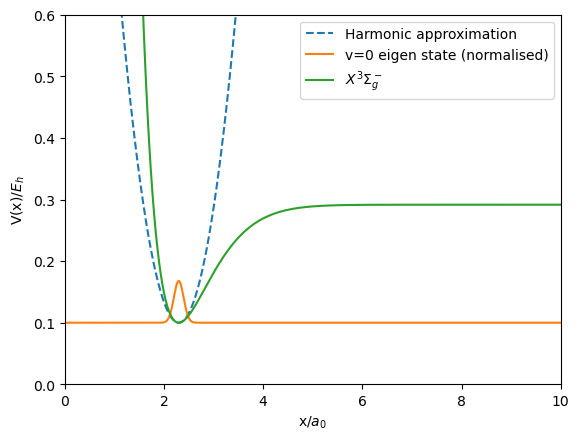

In [14]:
X_harm = V_harm(x_grid,X_re,X_k) + X_Te
plt.plot(x_grid, X_harm, label='Harmonic approximation', linestyle='--')
#plt.plot(x_grid, X_eigen_0, label='v=0 eigen state')
plt.plot(np.linspace(0,500,30000), X_eigen_normalised + X_Te, label='v=0 eigen state (normalised)')
plt.plot(x_grid, V_X(x_grid),label='$X^3Σ_g^-$')
plt.ylim(0,0.6)
plt.xlim(0,10)
plt.xlabel('x/$a_0$')
plt.ylabel('V(x)/$E_h$')
plt.legend()

<div>
<img src="TDQMS%20images/2_harmonicapprox_0theigen.png" width="400"/>
</div>

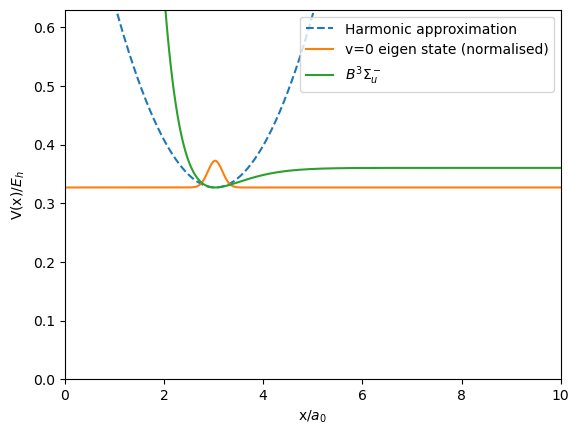

In [15]:
B_eigen_normalised = eigen_ho(np.linspace(0,500,30000) - B_re,0,m,B_k)/np.trapz(B_eigen_0)

plt.plot(x_grid, B_harm, label='Harmonic approximation', linestyle='--')
plt.plot(np.linspace(0,500,30000), B_eigen_normalised + B_Te, label='v=0 eigen state (normalised)')
plt.plot(x_grid, V_B(x_grid),label='$B^3Σ_u^-$')

plt.ylim(0,0.63)
plt.xlim(0,10)

plt.xlabel('x/$a_0$')
plt.ylabel('V(x)/$E_h$')
plt.legend(loc=1)

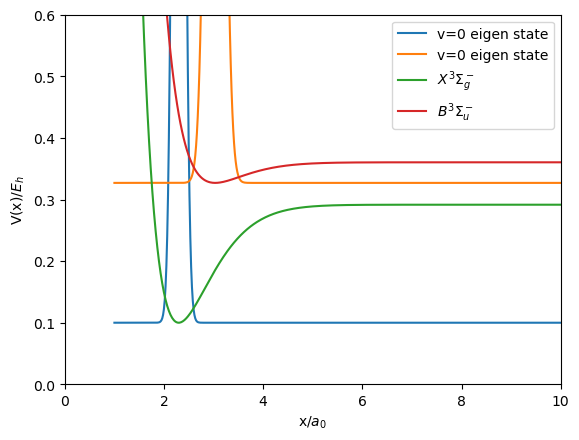

In [16]:
plt.plot(x_grid, X_eigen2_0, label='v=0 eigen state')
plt.plot(x_grid, B_eigen2_0, label='v=0 eigen state')
plt.plot(x_grid, V_X(x_grid),label='$X^3Σ_g^-$')
plt.plot(x_grid, V_B(x_grid),label='$B^3Σ_u^-$')

plt.xlim(0,10)
plt.ylim(0,0.6)
plt.xlabel('x/$a_0$')
plt.ylabel('V(x)/$E_h$')
plt.legend()

Plot transition dipole to compare to PESs and eigen function

(0.0, 8.0)

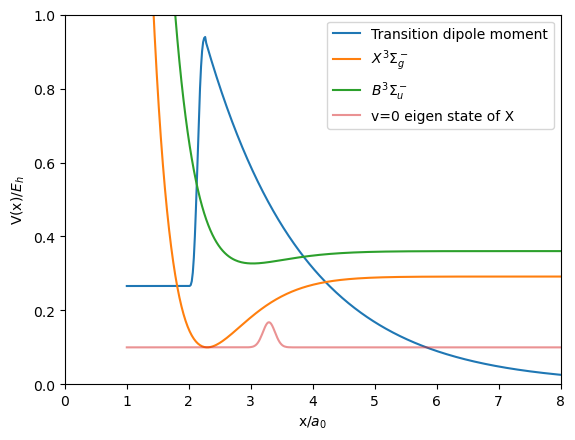

In [17]:
td = transition_dipole_moment(x_grid)
plt.plot(x_grid, td, label='Transition dipole moment')
plt.plot(x_grid, V_X(x_grid),label='$X^3Σ_g^-$')
plt.plot(x_grid, V_B(x_grid),label='$B^3Σ_u^-$')
plt.plot(x_grid, X_eigen_normalised + X_Te, label='v=0 eigen state of X', alpha=0.5)

plt.legend()
plt.xlabel('x/$a_0$')
plt.ylabel('V(x)/$E_h$')
plt.ylim(0,1)
plt.xlim(0,8)

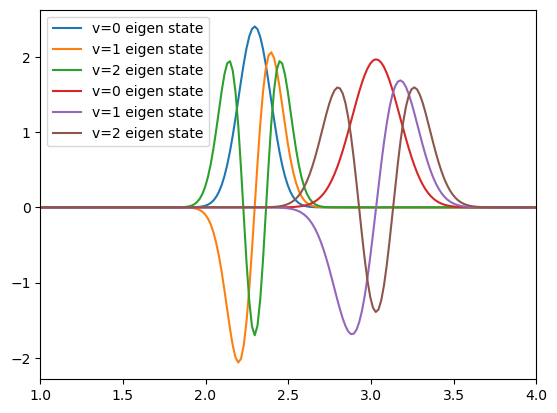

In [18]:
plt.plot(x_grid, eigen_ho(x_grid - X_re,0,m,X_k), label='v=0 eigen state')
plt.plot(x_grid, eigen_ho(x_grid - X_re,1,m,X_k), label='v=1 eigen state')
plt.plot(x_grid, eigen_ho(x_grid - X_re,2,m,X_k), label='v=2 eigen state')
plt.plot(x_grid, eigen_ho(x_grid - B_re,0,m,B_k), label='v=0 eigen state')
plt.plot(x_grid, eigen_ho(x_grid - B_re,1,m,B_k), label='v=1 eigen state')
plt.plot(x_grid, eigen_ho(x_grid - B_re,2,m,B_k), label='v=2 eigen state')
plt.legend()
plt.xlim(1,4)
plt.show()


Excite X_eigen_0 to ES potential

### Propagation of eigen state on GS potential (no TD moment)

In [23]:
dt = 1
nsteps = 10000
time_GS_0=np.linspace(0,dt*(nsteps+1), nsteps+1)
# Define the initial wavefunction. 
v=0 #vibrational mode
m=14583 #reduced mass of O2 in atomic units

X_eigen_0 = eigen_ho(x_grid - X_re,v,m,X_k)
X_eigen_0_normalised = eigen_ho(x_grid - X_re,v,m,X_k)/np.trapz(eigen_ho(x_grid - X_re,v,m,X_k))
EF0 = X_eigen_0
EF0 = X_eigen_0_normalised

wf_dynamics_GS_0=np.zeros((nsteps+1,len(x_grid)),dtype=complex128)
wf_dynamics_GS_0[0]=EF0

for step in range(nsteps):
    EF = propagator(x_grid,wf_dynamics_GS_0[step],m,dt,V_X)
    wf_dynamics_GS_0[step+1]=EF # Add the new wavefunction to the array
    

(0.0, 10.0)

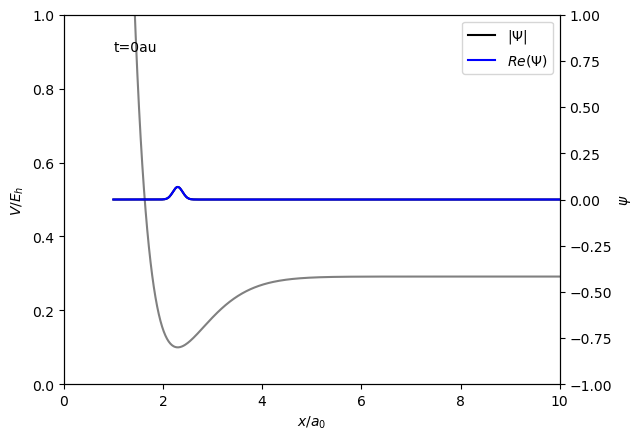

In [24]:
animate_dynamics(x_grid,wf_dynamics_GS_0,dt,V_X(x_grid),frame_delay=1000, blit=True)
plt.xlim(0,10)


### Propagation of eigen state on excited state potential

In [26]:
dt = 1
nsteps = 5000
time_ES_0=np.linspace(0,dt*(nsteps+1), nsteps+1)
# Define the initial wavefunction. 
v=0 #vibrational mode

EF0 = X_eigen_0 * transition_dipole_moment(x_grid)
#EF0 = X_eigen_0_normalised * transition_dipole_moment(x_grid)
#EF0 = eigen_ho(x_grid - X_re,4,m,X_k) * transition_dipole_moment(x_grid)

wf_dynamics_ES_0=np.zeros((nsteps+1,len(x_grid)),dtype=complex128)
wf_dynamics_ES_0[0]=EF0

for step in range(nsteps):
    EF = propagator(x_grid,wf_dynamics_ES_0[step],m,dt,V_B)
    wf_dynamics_ES_0[step+1]=EF # Add the new wavefunction to the array
    

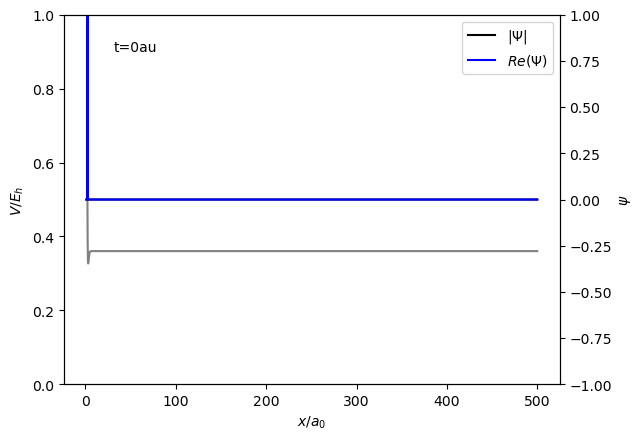

In [27]:
animate_dynamics(x_grid,wf_dynamics_ES_0,dt,V_B(x_grid),frame_delay=0.1,  blit=True)
#plt.xlim(0,10)
#plt.ylim(0,3)

Bond dissociates but there are some bound states left over

---
## Autocorrelation function

The autocorrelation function provides information about the overlap between the WF at t=0 and the time-evolved wavefunction

$$\langle \psi(0) | \psi(t) \rangle = \int_{-\infty}^{\infty} \psi^*(x,0)\psi(x,t)dx$$

In this case the integral will be over our spatial domain: x_grid

In the context of the Schumann-Runge band, the autocorrelation function can help you understand the vibronic transitions and the time-dependent behavior of the molecular system.

At time t=0, the autocorrelation function will have its maximum value, since the overlap between the wavefunction at t=0 and itself is perfect.

<font color='red'>look at decay time (L7 - typical timescale of thermal fluctutations)</font> 

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


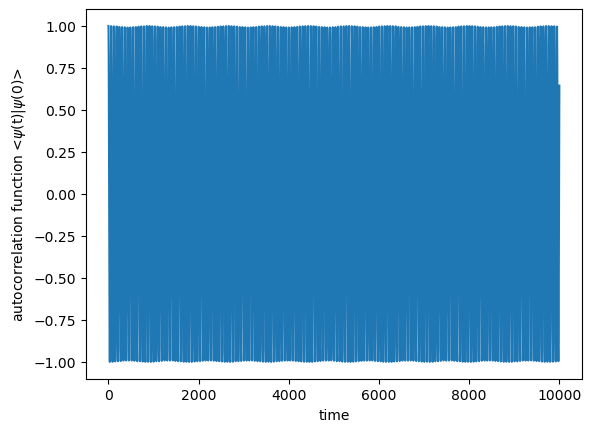

In [28]:
auto_GS_0 = np.trapz(conj(wf_dynamics_GS_0[0])*wf_dynamics_GS_0)
normalized_auto_GS_0 = auto_GS_0/np.max(auto_GS_0)
plt.xlabel('time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_GS_0, normalized_auto_GS_0)

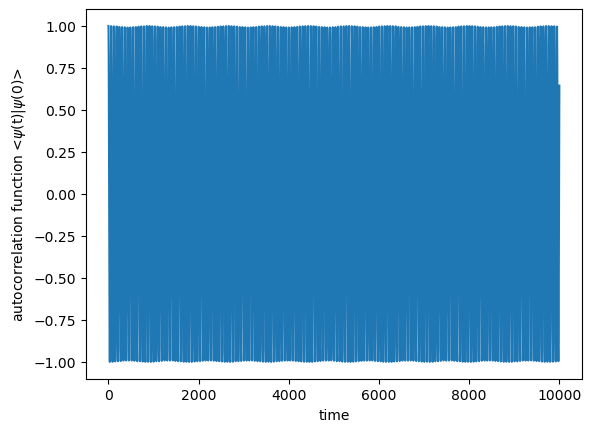

In [29]:
plt.xlabel('time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_GS_0, normalized_auto_GS_0)

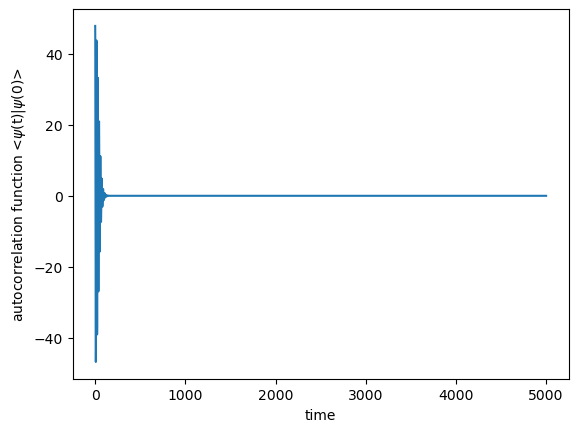

In [30]:
auto_ES_0 = np.trapz(conj(wf_dynamics_ES_0[0])*wf_dynamics_ES_0)
normalized_auto_ES_0 = auto_ES_0/np.max(auto_ES_0)
plt.xlabel('time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_ES_0, auto_ES_0)

(0.0, 100.0)

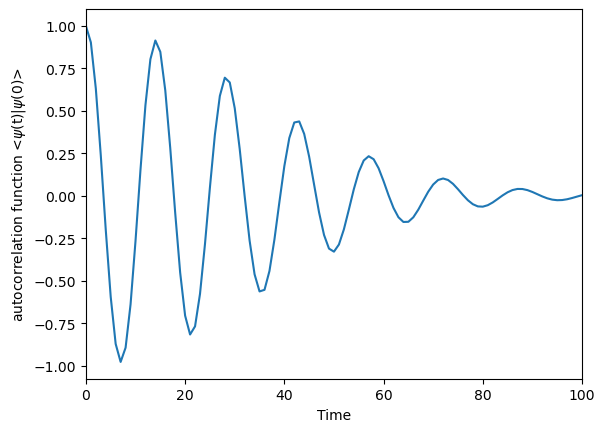

In [31]:
plt.xlabel('Time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_ES_0, normalized_auto_ES_0)
plt.xlim(0,100)

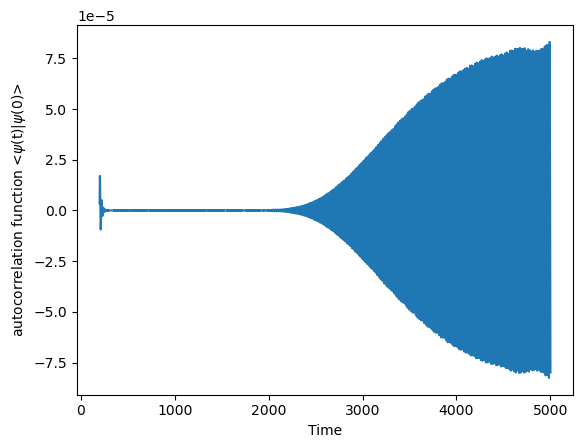

In [32]:
plt.xlabel('Time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_ES_0[200:], normalized_auto_ES_0[200:])

A = 0.9977087684722306 tau = 46.92214367075073 beta = 1.9349335914407306


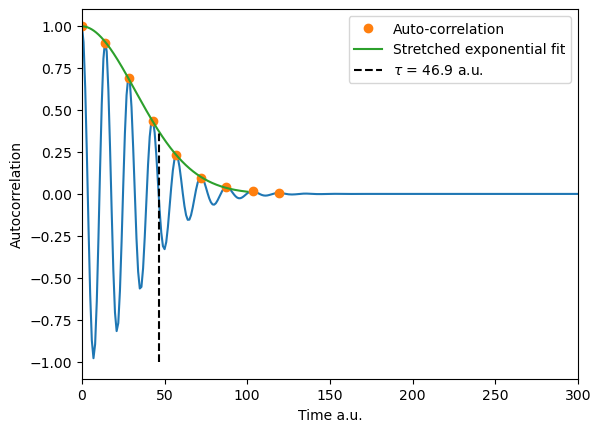

In [39]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the stretched exponential (Kohlrausch) function
def stretched_exponential(t, A, tau, beta):
    return A * np.exp(-(t/tau)**beta)

time_list = [0, 14.1, 28.2, 42.7, 57.1, 72, 87.2, 103.4, 119]
poi_list = [1, 0.9, 0.69, 0.435, 0.23, 0.0957, 0.04, 0.0156, 0.0069]

# Fit the stretched exponential function to the data
popt, pcov = curve_fit(stretched_exponential, time_list, poi_list, bounds=(0, np.inf))

# Print the fitted parameters
print("A =", popt[0], "tau =", popt[1], "beta =", popt[2])

plt.xlabel('Time')
plt.ylabel('autocorrelation function <$\psi$(t)|$\psi$(0)>')
plt.plot(time_ES_0, normalized_auto_ES_0)

# Plot the data and the fitted curve
t = np.linspace(0, 100, 1000)
plt.plot(time_list, poi_list, 'o', label='Auto-correlation')
plt.plot(t, stretched_exponential(t, *popt), '-', label='Stretched exponential fit')
plt.vlines(46.9, -1, 1/np.e, linestyle='--', color='k', label=r'$\tau$ = 46.9 a.u.')
plt.legend()
plt.xlim(0,300)
plt.xlabel('Time a.u.')
plt.ylabel('Autocorrelation')
plt.show()



---
## Power spectrum

If we know how the system is evolving in time, we can know what the energy contribution is to the system  
Peaks at eigenfunctions of $\hat{H}$, where the peak weights are the energy composition of teh wavepacket: the power spectrum  
Height of peak determined by contribution of the state to the WF

Not performing integral up to $\infty$ therefore wont be delta functions and will have some broardening (associated with how long we propagate the WF for)  
Time $\rightarrow$ Freq domain

The peaks in the power spectrum correspond to the frequencies of the vibronic transitions in the system.

The resolution &Delta;&omega; of the frequency grid depends on the total length of the time interval (the time range), so if N is the number of points in the time grid and &Delta;t the spacing between them, then

$$\Delta\omega=\frac{\sqrt{2\pi}}{N \Delta t}.$$

The range of the frequency grid, spanning from \[-&Omega;,&Omega;\] depends on the resolution of the time grid:

$$\Omega=\frac{\sqrt{\pi}}{\Delta t}.$$

In [ ]:
# a single eigen function should have a single peak in the power spectrum

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_69738/3803818029.py:9: RuntimeWarning: divide by zero encountered in divide
  GS_wavelegth_nm = 3e8/GS_freq_Hz * 1e9


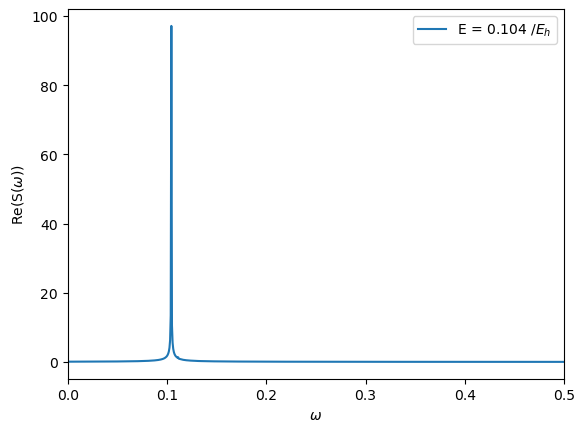

In [40]:
GS_freq = 2*pi*fftshift(fftfreq(len(time_GS_0),d=(time_GS_0[2]-time_GS_0[1]))) 

GS_power = ifftshift(ifft(normalized_auto_GS_0,norm="ortho"))

# atomic time units
atomic_time = 2.419e-17 #0.02419 fs
GS_freq_Hz = GS_freq /(atomic_time*2*pi) 
GS_cm_1 = GS_freq_Hz/3e10
GS_wavelegth_nm = 3e8/GS_freq_Hz * 1e9

wavelegth_max = GS_wavelegth_nm[np.argmax(abs(GS_power))]
E_value = GS_freq[np.argmax(abs(GS_power))]

plt.xlim(0,0.5)
plt.xlabel('$\omega$')
#plt.xlabel('Wavelegth (nm)')
plt.ylabel("Re(S($\omega$))")
plt.plot(GS_freq,abs(GS_power), label= f"E = {E_value:.3f} $/E_h$")
#plt.xlim(-1000,1000)
plt.legend()
plt.show()

<div>
<img src="TDQMS%20images/power%20spectrum%20no%20TD.png" width="400"/>
</div>

Expected value for power spectrum peak:

In [ ]:
omega_value_GS

0.10359996697601667

In [41]:
omega_value_GS =(0.5)*(X_k/m)**0.5 + X_Te
omega_value_nm = ((2*np.pi*137/(omega_value_GS)) * 5.29e-2)
omega_value_nm

439.53806362953964

---
## Absorption spectrum
The power spectrum is calculated with an unperturbed Hamiltonian (no light), while the absoption spectrum is a direct consequence of the interaction with light. In your report you should explain these differences.

http://pgopher.chm.bris.ac.uk/Help/makeo2.htm

Think: absorption spectrum is basically power spectrum but includes the interaction with light  

L3: the absorption spectrum can be calculated from an autocorrelation function of a WF which has been transformed by the dipole moment and propapagted by the unperturbed hamiltonian of the system (absence of external field - think this is just the one were using)

$$ \sigma(\omega_I) = \frac{2\pi\omega_I}{3\hbar c} |\mu_{01}|^2 \int_{-\infty}^{\infty} \langle \chi(0) | e^{-i \hat{H}_2t/\hbar} | \chi(0)\rangle e^{i(E_i/\hbar + \omega_I)t} dt $$

$$ \sigma(\omega_I) = \frac{2\pi\omega_I}{3\hbar c} \int_{-\infty}^{\infty} \langle \varphi(0)| \varphi(t)\rangle e^{i(E_i/\hbar + \omega_I)t} dt $$ 
where $$\varphi = \hat{\mu}\psi$$

- $\omega_I$ is the frequency of the incident light
-  $E_i/\hbar$ is the frequncy of the initial state

In [42]:
(X_k/m)**0.5 + X_Te

0.10719993395203335

In [43]:
def el_cons(lst):
    D = lst[0]
    r = lst[1]
    beta = lst[2]
    T = lst[3]
    kappa = 2*D*(r**-1 + 2*beta*r)**2
    return kappa #returns k

def omega(lst):
    om = (el_cons(lst)/m)**0.5
    return om

def shift2(t, lst,n):
    w = lst[3] + omega(lst)*(n+1/2)
    return np.e**(1j*w*t)


def freq(time_arr):
    return 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(time_arr), d = dt))


def ifft2(time_arr, funct):
    freq_arr = freq(time_arr)
    inverse = np.fft.ifftshift(np.fft.ifft(funct, norm = 'ortho'))
    return inverse

list_X = [0.19158, 2.29716, 0.21098, 0.1, 29200]
list_B = [0.03342, 3.03150, 0.19459, 0.327, 29200]

- apply shift to autocorrelation function (multiply by $e^{i\omega_I t}$)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_69738/3791998595.py:15: RuntimeWarning: divide by zero encountered in divide
  ES_wavelegth_nm = 3e8/ES_freq_Hz * 1e9
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_69738/3791998595.py:16: RuntimeWarning: divide by zero encountered in divide
  w = ((2*np.pi*137/(ES_freq)) * 5.29e-2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


180.55867964455956

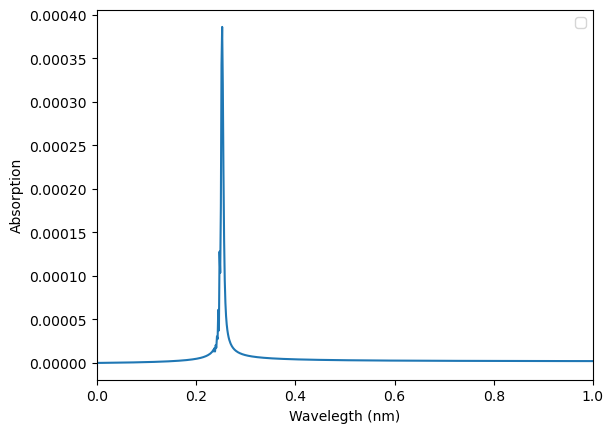

In [44]:

#omega =(0.5)*(X_k/m)**0.5 + X_Te

ES_freq = 2*pi*fftshift(fftfreq(len(time_ES_0[200:]),d=(time_ES_0[2]-time_ES_0[1]))) 

c_atomic = 137

shif = shift2(time_ES_0[200:], list_X, 0)

absorb_0 = ES_freq * ifft2(time_ES_0[200:], shif*normalized_auto_ES_0[200:])

# atomic time units
atomic_time = 2.419e-17 #0.02419 fs
ES_freq_Hz = ES_freq /(atomic_time*2*pi) 
ES_cm_1 = ES_freq_Hz/3e10
ES_wavelegth_nm = 3e8/ES_freq_Hz * 1e9
w = ((2*np.pi*137/(ES_freq)) * 5.29e-2)

#plt.xlabel('$\omega$')
plt.xlabel('Wavelegth (nm)')
plt.ylabel("Absorption")
plt.plot(ES_freq,abs(absorb_0)) #label= f"{wavelegth_max} nm")
#plt.xlim(170,195)
plt.xlim(0,1)

plt.legend()

wavelegth_max =ES_wavelegth_nm[np.argmax(abs(absorb_0))]
wavelegth_max

<div>
<img src="TDQMS%20images/Absorption%20spectrum.png" width="400"/>
</div>

In [45]:
# most intense vibronic peak at 178.6 nm
# energy of transition
E_max = ES_freq[np.argmax(abs(absorb_0))]
E_max

0.25253328094757227

### Removal of first ~200 time points (ChatGPT):  
When you exclude the first 200 points out of 10,000 from the autocorrelation function, you are essentially removing the short-time behavior of the function. The short-time behavior can be affected by various factors, such as initial conditions, transient effects, and numerical artifacts, which might not be representative of the system's long-term behavior.

By excluding these initial points, you are effectively focusing on the more stable and long-lived behavior of the system, which can result in a higher resolution absorption spectrum. This improvement in resolution can help reveal finer details in the spectrum that may have been obscured by the noise or artifacts present in the short-time behavior of the autocorrelation function.

However, it's essential to ensure that the removal of the initial points does not lead to a loss of relevant information. It would be helpful to analyze and understand the reasons behind the change in resolution, such as checking the numerical stability of your simulation, the quality of the initial conditions, or the presence of transient effects in the system.

---
### Expectation value - L1
$$ \langle \hat{x} \rangle = \langle \psi(t) | \hat{x} | \psi(t) \rangle $$

$\psi(0)$ or $\psi(t)$ first?

In [46]:
def expectation(wf_dynamics):
    x = wf_dynamics[0]
    integral = trapz((conj(wf_dynamics)*x_grid*wf_dynamics), x_grid)
    expects = np.abs(integral)
        
    return expects

In [47]:
ex =  expectation(wf_dynamics_ES_0)


Text(0, 0.5, '<$\\psi(0) | \\hat x | \\psi(t)$>  / a$_0$')

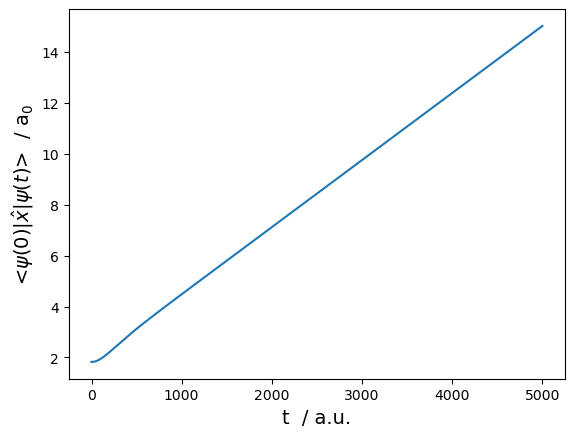

In [48]:

plt.plot(time_ES_0, ex)
plt.xlabel('t  / a.u.', fontsize=14)
plt.ylabel('<$\psi(0) | \hat x | \psi(t)$>  / a$_0$', fontsize=14)

---
### Spread (squared) - L1
$$ \Delta x(t) = (\langle \psi(t) | \hat{x}^2 | \psi(t) \rangle - \langle \psi(t) | \hat{x} | \psi(t) \rangle^2)^\frac{1}{2}$$

In [49]:
squares_int = np.trapz((conj(wf_dynamics_ES_0)*x_grid**2*wf_dynamics_ES_0), x_grid)

In [50]:
squares_int = np.trapz((conj(wf_dynamics_ES_0)*x_grid**2*wf_dynamics_ES_0), x_grid)
squared_int = np.trapz((conj(wf_dynamics_ES_0)*x_grid*wf_dynamics_ES_0), x_grid)**2
spread = (squares_int - squared_int)**0.5


In [600]:
spread = (squares_int - squared_int)**0.5
#plt.plot(time_ES_0[:100], spread[:100])
plt.plot(time_ES_0, spread)
plt.xlabel('t  / a.u.', fontsize=14)
plt.ylabel(r'$(\langle \psi(t) | \hat{x}^2 | \psi(t) \rangle - \langle \psi(t) | \hat{x} | \psi(t) \rangle^2)^\frac{1}{2} /  a_0$', fontsize=14)

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$(\\langle \\psi(t) | \\hat{x}^2 | \\psi(t) \\rangle - \\langle \\psi(t) | \\hat{x} | \\psi(t) \\rangle^2)^\\frac{1}{2} /  a_0$')

### Transition dipole

<font color='red'>Transition dipoles and absorption spectra: Molecular spectroscopy p.259</font>

μij is the electronic transition dipole moment. It is non-zero if φi and φj have
different space symmetry, and therefore contributes to off-diagonal terms.


FC factor: $F_{v′′,v′} = |\langle v′′|v′ \rangle|^2$  
square of the overlap of the initial and final vibrational wavefunctions.

---

## Eigenstates $\Lambda_v^B$ of the excited state curve

$$\int_{-\infty}^{\infty}e^{i E_v^B t} \varphi^B(x,t) dt= \sum_i c_i \int_{-\infty}^{\infty}e^{i (E_v^B-E_i^B) t} \Lambda_i^B(x) dt = 2 \pi \sum_i c_i \delta(E_v^B-E_i^B) \Lambda_i^B(x) \propto \Lambda_v^B(x).$$

The left-hand side of the equation can be calculated from the dynamics, the right-hand side is our unknown.

$\varphi^B(x,t)$ is the time-dependent wavefunction of the excited state (B) at position x and time t (WF_dynamics).  
$\Lambda_v^B(x)$ is the eigenfunction of the excited state potential (B) where v is the vibraional eigenstate.

Eigenvalues for the HO ($\hbar$=1): $$ E_v = \left(v+\frac{1}{2}\right)\sqrt{\frac{k}{\mu}} $$ but cant use for excited vibraitonal states

In [51]:
def eigen_energy(v, m, k):
    return (v+0.5) * np.sqrt(k/m)

In [52]:
energy_GS0 = eigen_energy(0, m, X_k) + X_Te
energy_GS0

0.10359996697601667

In [53]:
energy_ES0 = eigen_energy(0, m, X_k) + B_Te
energy_ES0 - energy_GS0

0.227

In [54]:
((2*np.pi*137/(energy_ES0 - energy_GS0)) * 5.29e-2)


200.59968668159743

In [55]:
# energy of transition
# most intense vibronic peak at 178.6 nm
E_max = ES_freq[np.argmax(abs(absorb_0))]
E_max

0.25253328094757227

In [56]:
# energy of excited state due to most intense vibronic peak
E_new = E_max + omega_value_GS
E_new

0.3561332479235889

In [57]:
exp_int = e**(1j*E_new*time_ES_0[0:])[:, np.newaxis]
exp_int

array([[ 1.        +0.j        ],
       [ 0.93722715+0.34871948j],
       [ 0.75678944+0.65365873j],
       ...,
       [-0.56276392+0.82661767j],
       [-0.81569531+0.57848177j],
       [-0.96621965+0.25771997j]])

In [58]:
exp_int = e**(1j*E_max*time_ES_0[0:])[:, np.newaxis]


In [59]:
integrand = exp_int * wf_dynamics_ES_0[:][0:]

In [60]:
lambda_B = np.trapz(integrand, time_ES_0[0:], axis = 0)

In [61]:
integral = np.trapz(np.abs(lambda_B)**2, x_grid)

# Normalize the eigenfunction
normalized_eigenfunction = lambda_B /integral**0.5

In [62]:
trapz(abs(normalized_eigenfunction)**2, x_grid)

0.9999999999999998

<div>
<img src="TDQMS%20images/1_eigenfunctionB.png" width="400"/>
</div>

Comparison to Morse oscillator eigenfunctions (anharmonic oscillator):
<div>
<img src="TDQMS%20images/morseoscillator.png" width="300"/>
<img src="TDQMS%20images/morse_dissociation.png" width="180"/>
</div>
https://scipython.com/blog/the-morse-oscillator/


- counting the peaks and troughs of the eigen function, can conclude it is the 14th vibrational state (like in the image)
- uneven spacing between energy levels (spacing decreases as you go up in energy)

The Schrodinger equation for the Morse oscillator is exactly solvable, giving vibrational eigenvalues: $$ E_{v, Morse} = \omega \left (v+\frac{1}{2} \right) - \frac{\omega^2}{4D_e} \left (v+\frac{1}{2} \right) ^2 $$

In [ ]:
def morse_eigen_energy(v, m, k, diss_E):
    return (v+0.5) * np.sqrt(k/m) - (k/m)/(4*diss_E) * (v+0.5)**2


In [ ]:
B_De

0.03342

In [ ]:
morse_eigen_energy(14, m, B_k, B_De) + B_Te

0.3574351222596831

In [ ]:
E_new

0.35891635851326953

In [ ]:
X_k

0.7559688503076477

#### FC factor

 $$ FC=\langle \phi_f|\phi_i\rangle^2$$

Compare eigenfunction to GS v=0

In [64]:
FC_v14 = abs(np.trapz(conj(normalized_eigenfunction)*X_eigen_0_normalised, x_grid))
FC_v14

0.019720332737352585

(0.0, 6.0)

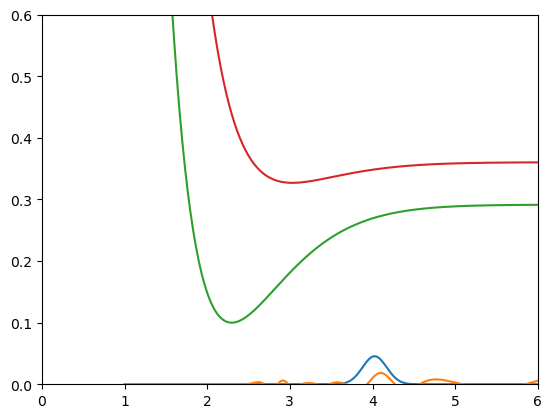

In [65]:
plt.plot(x_grid, B_eigen_normalised)
plt.plot(x_grid, normalized_eigenfunction)
plt.plot(x_grid, V_X(x_grid))
plt.plot(x_grid, V_B(x_grid))
plt.ylim(0,0.6)
plt.xlim(0,6)

Compare to v'=0 $\rightarrow$ v"=0 transition

In [66]:
B_eigen_normalised = B_eigen_0/trapz(B_eigen_0)

In [67]:
FC_v0 = abs(np.trapz(conj(B_eigen_normalised)*X_eigen_0_normalised, x_grid))
FC_v0

9.769523193345586e-08

(0.0, 6.0)

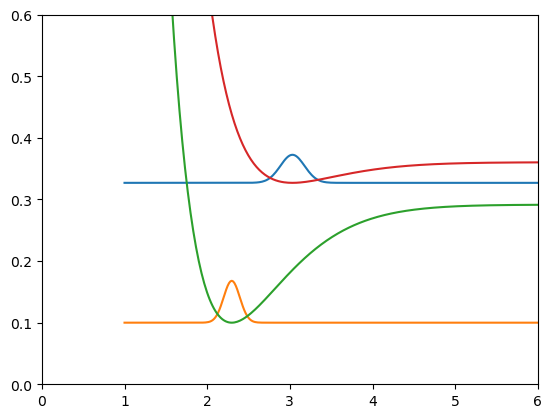

In [68]:
plt.plot(x_grid, B_eigen_normalised+B_Te)
plt.plot(x_grid, X_eigen_0_normalised+X_Te)
plt.plot(x_grid, V_X(x_grid))
plt.plot(x_grid, V_B(x_grid))
plt.ylim(0,0.6)
plt.xlim(0,6)

### Bound vs unbound (chatGPT):  
A bound state occurs when the eigenvalue (energy) of the eigenfunction is lower than the potential energy at large distances, i.e., when the energy is below the potential energy barrier or asymptotic value of the potential energy surface. In such cases, the particle or system is trapped within a potential well and cannot escape. Bound states usually have localized eigenfunctions, which decay exponentially at large distances from the potential well.

On the other hand, an unbound state occurs when the eigenvalue (energy) of the eigenfunction is greater than or equal to the potential energy at large distances. In this case, the particle or system has enough energy to escape the potential well. Unbound states typically have non-localized eigenfunctions that do not decay exponentially at large distances from the potential well, and they may exhibit oscillatory behavior.

# TSQMS CW Part 2

A range of modern lighting and display technologies relies on colour conversion layers (CCLs), which enable the efficient conversion of light from shorter to longer wavelengths.

The newly developed optical material for CCL has been studied through spectroscopic analysis. The material was a transparent and chemically stable polyvinylcarbazole (PVK) film doped with two fluorescent dyes, BV440 and Atto505. The doping concentration for each dye was kept relatively low, less than 1% by weight. Additionally, both dyes were characterized through absorption and photoluminescence spectroscopies conducted under steady-state conditions. No phosphorescence or sample degradation effects were observed during the measurements.

The spectroscopic data are provided to you as ASCII files with space-separation between numbers.  Data set includes:

* Separately measured [absorption spectrum of BV440](Abs-BV440) (first column – wavelength (nm), second - optical density (OD))
* Separately measured [absorption spectrum of Atto505](Abs-Atto505) (first column - wavelength, second - OD)
* Separately measured [fluorescence spectrum of BV440](Fluorescence-BV440) (first column - wavelength, second – photon counts in arb.u.)
* Separately measured [fluorescence spectrum of Atto505](Fluorescence-Atto505) (first column - wavelength, second – photon counts in arb.u.)
* [Transient absorption spectrum](TA_2D-DATA.mx3) of the studied material (BV440 and Atto505 dopped PVK) after excitation at 370nm (2D matrix; the first column contains pump-probe delay times (ps) and the first row contains probe wavelengths; matrix elements show the change in transmission dT/T at the corresponding time/wavelength)

Your task is to analyse the experimental dataset and present a report addressing the following questions:

1. Identify excited states involved in the photochemistry and spectroscopy of the material. Propose a Jablonski diagram showing key processes happening in the material. When possible, specify the energies of excited states
2. Discuss and interpret cross-sections through transient absorption spectrum at (at least) two representative times and two representative wavelengths
3. Analyse the dynamics of the excited states and extract the timescale(s) of the dynamics using additional information provided by SVD or global fitting. Relate the identified timescales to the relevant dynamical processes on the Jablonski diagram proposed above.
4. Where possible, identify the vibrational modes of BV440 and Atto505 (use multiple approaches if you can). Assign the observed vibrational coherences (if any) to the electronic states.

Please support your analysis with the figures and references to the relevant theoretical background.

Transparent film doped with two fluorescent dyes: BV440 abd Atto505 (less than 1% by weight doping conc). No phosphorescence or sample degradation effects were observed.

## Setup

In [69]:
plt.rcParams["figure.figsize"] = (8, 6)

In [70]:
BV440_abs_wavelength, BV440_abs_OD = np.loadtxt('Abs-BV440', skiprows=1)[:,0] , np.loadtxt('Abs-BV440', skiprows=1)[:,1]
Atto505_abs_wavelength, Atto505_abs_OD = np.loadtxt('Abs-Atto505', skiprows=1)[:,0] , np.loadtxt('Abs-Atto505', skiprows=1)[:,1]
BV440_flu_wavelength, BV440_flu_PC = np.loadtxt('Fluorescence-BV440', skiprows=1)[:,0] , np.loadtxt('Fluorescence-BV440', skiprows=1)[:,1]
Atto505_flu_wavelength, Atto505_flu_PC = np.loadtxt('Fluorescence-Atto505', skiprows=1)[:,0] , np.loadtxt('Fluorescence-Atto505', skiprows=1)[:,1]


In [71]:
import pandas as pd
%matplotlib inline

### Absorption spectra

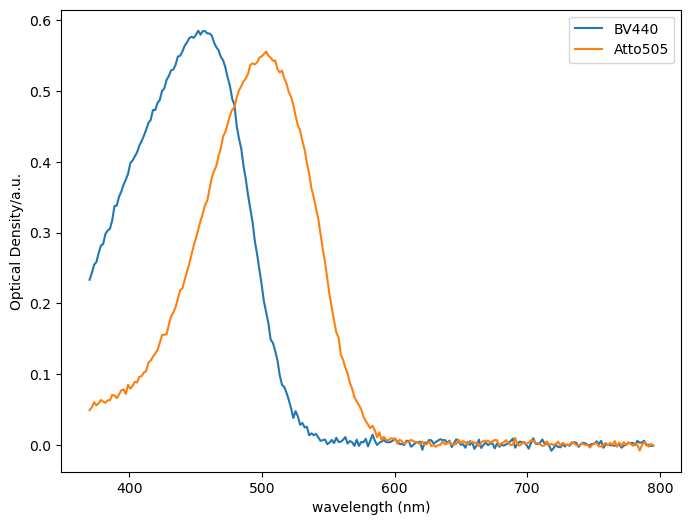

In [72]:
plt.plot(BV440_abs_wavelength, BV440_abs_OD, label='BV440')
plt.plot(Atto505_abs_wavelength, Atto505_abs_OD, label='Atto505')
plt.xlabel('wavelength (nm)')
plt.ylabel('Optical Density/a.u.')
plt.legend()

### Flourescence spectra

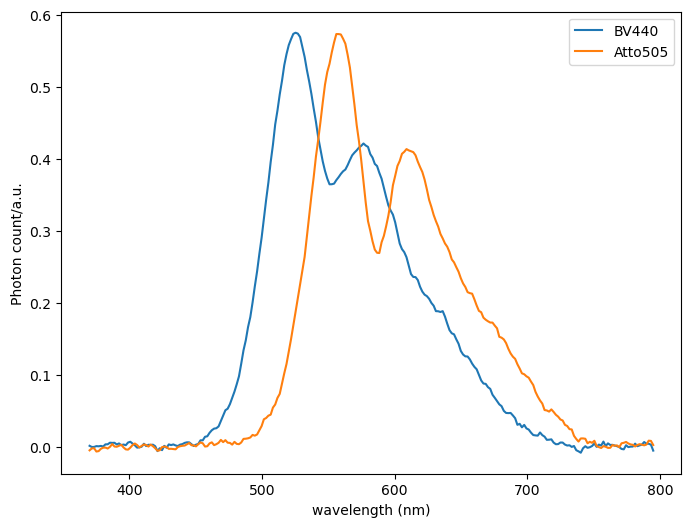

In [73]:
plt.plot(BV440_flu_wavelength, BV440_flu_PC, label='BV440')
plt.plot(Atto505_flu_wavelength, Atto505_flu_PC, label='Atto505')
plt.xlabel('wavelength (nm)')
plt.ylabel('Photon count/a.u.')
plt.legend()

---
## Q1 
Identify excited states involved in the photochemistry and spectroscopy of the material. Propose a Jablonski diagram showing key processes happening in the material. When possible, specify the energies of excited states

- Pump pulse at 370 nm

In [79]:
%matplotlib inline

### BV440

Gaussian fit peaks if have time

In [80]:
def gaussian(x,a, std_dev, mean):
    return a * np.exp(-(x-mean)**2/(2*std_dev)**2)

popt_BV440_abs, pcov_BV440_abs = curve_fit(gaussian,BV440_abs_wavelength[30:65],BV440_abs_OD[30:65], p0 = [1,20,450])
popt_BV440_flu, pcov_BV440_flu = curve_fit(gaussian,BV440_flu_wavelength[70:100],BV440_flu_PC[70:100], p0 = [1,20,450], maxfev=5000)


In [81]:
BV400_abs_maxwavelength = BV440_abs_wavelength[np.argmax(BV440_abs_OD)]
BV400_flu_maxwavelength = BV440_flu_wavelength[np.argmax(BV440_flu_PC)]
BV400_flu_maxwavelength2 = BV440_flu_wavelength[115:130][np.argmax(BV440_flu_PC[115:130])]
print(BV400_abs_maxwavelength, BV400_flu_maxwavelength, BV400_flu_maxwavelength2)

451.927710843374 525.321285140562 576.526104417671


In [77]:
%matplotlib inline
%matplotlib qt

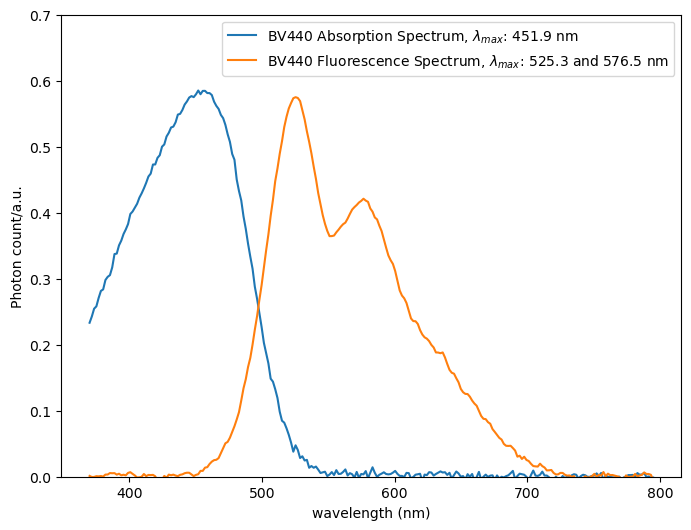

In [82]:
plt.plot(BV440_abs_wavelength, BV440_abs_OD, label=f'BV440 Absorption Spectrum, $\lambda_{{max}}$: {BV400_abs_maxwavelength:.1f} nm')
plt.plot(BV440_flu_wavelength, BV440_flu_PC, label=f'BV440 Fluorescence Spectrum, $\lambda_{{max}}$: {BV400_flu_maxwavelength:.1f} and {BV400_flu_maxwavelength2:.1f} nm')
#plt.vlines(576,0,0.6, label='BV440 - peak')
plt.ylim(0,0.7)
plt.xlabel('wavelength (nm)')
plt.ylabel('Photon count/a.u.')
plt.legend(loc = 'upper right')

<div>
<img src="TSQMS%20part%202%20images/2_BV400_abs_flu.png" width="500"/>
</div>

Absorption and fluorescence peaks red shifted 

Blue peak:
most intense: $ S_0^0 \rightarrow S_1^0$  
possible transitons to higher vibrational states on $S_1$ as the LHS of the absorption peak is wider than the RHS, suggesting lower intensity transitions at higher energies

Orange peak: Most intense peak is $ S_1^0 \rightarrow S_0^0$, red shifted compared to absorption peak (Stokes shift - solvent relaxation)  
2nd most intense peak: lower energy and less intense emission from $ S_1^0 \rightarrow S_0^1$  
Shape of RHS of peak suggests further lower intensities of emission from $ S_1^0 \rightarrow S_0^v$ for higher vibraional states (vibrationally hot states), which would then decay to the ground state via vibrational relaxation

strength of the vibronic bands corresponds to the magnitude of the FC overlap integral: $$ FC=\langle \phi_f|\phi_i\rangle^2$$

In [83]:
# calculate energies
BV400_abs_energy = 1240/BV400_abs_maxwavelength
BV400_flu_energy = 1240/BV400_flu_maxwavelength
BV400_flu_energy2 = 1240/BV400_flu_maxwavelength2
print(BV400_abs_energy, BV400_flu_energy, BV400_flu_energy2)
print("units = eV")

2.743801652892559 2.3604602270555417 2.150813277141164
units = eV


In [86]:
%matplotlib inline

- pump pulse 370 nm
- BV440 absorbs much more efficiently at 370 nm, atto505 absorbs minimally
- therefore assume population of atto505 at early times = 0

### Atto505

In [88]:
Atto505_abs_maxwavelength = Atto505_abs_wavelength[np.argmax(Atto505_abs_OD)]
Atto505_flu_maxwavelength = Atto505_flu_wavelength[np.argmax(Atto505_flu_PC)]
Atto505_flu_maxwavelength2 = Atto505_flu_wavelength[130:150][np.argmax(Atto505_flu_PC[130:150])]
print(Atto505_abs_maxwavelength, Atto505_flu_maxwavelength, Atto505_flu_maxwavelength2)

503.132530120482 556.044176706827 608.955823293173


<font color='red'>check y-axis label</font> 

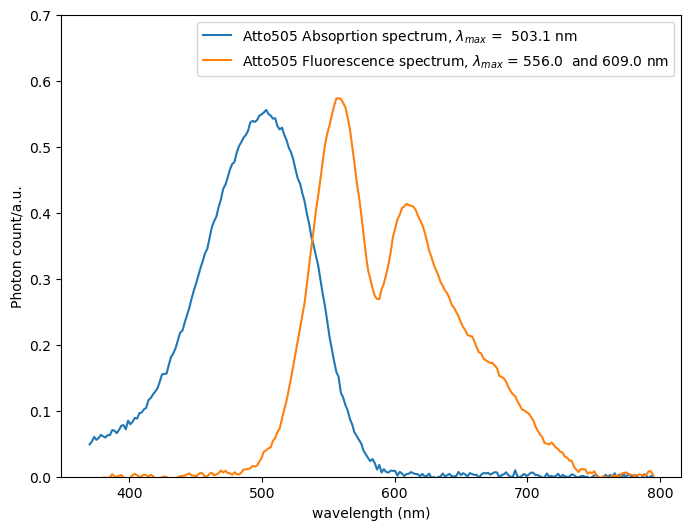

In [89]:

plt.plot(Atto505_abs_wavelength, Atto505_abs_OD, label=f'Atto505 Absoprtion spectrum, $\lambda_{{max}}$ =  {Atto505_abs_maxwavelength:.1f} nm')
plt.plot(Atto505_flu_wavelength, Atto505_flu_PC, label=f'Atto505 Fluorescence spectrum, $\lambda_{{max}}$ = {Atto505_flu_maxwavelength:.1f}  and {Atto505_flu_maxwavelength2:.1f} nm')
#plt.vlines(608,0,0.6, label='BV440 - peak')
plt.ylim(0,0.7)
plt.xlabel('wavelength (nm)')
plt.ylabel('Photon count/a.u.')
plt.legend()

<div>
<img src="TSQMS%20part%202%20images/1_Atto505_abs_flu.png" width="500"/>
</div>

Energies

In [90]:
Atto505_abs_energy = 1240/Atto505_abs_maxwavelength
Atto505_flu_energy = 1240/Atto505_flu_maxwavelength
Atto505_flu_energy2 = 1240/Atto505_flu_maxwavelength2
print(Atto505_abs_energy, Atto505_flu_energy, Atto505_flu_energy2)
print("units = eV")

2.4645593869731797 2.2300386407135906 2.036272505440875
units = eV


#### Donor emission and acceptor absorption overlap

Text(0, 0.5, 'Photon count/a.u.')

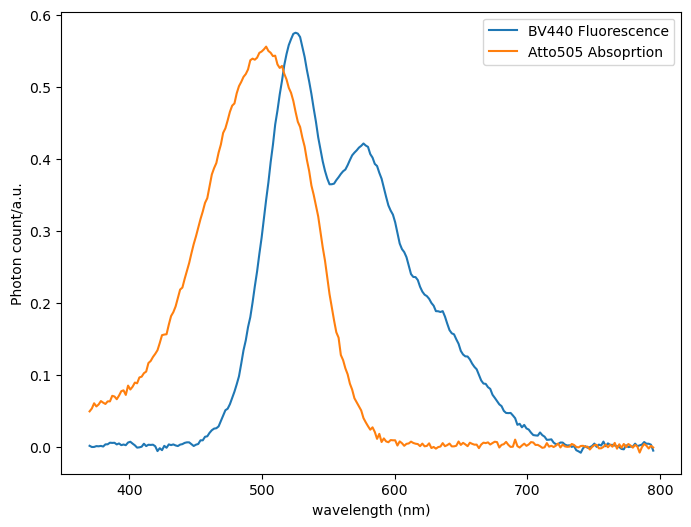

In [91]:
plt.plot(BV440_flu_wavelength, BV440_flu_PC, label=f'BV440 Fluorescence')
plt.plot(Atto505_abs_wavelength, Atto505_abs_OD, label=f'Atto505 Absoprtion')
plt.legend(loc=1)
plt.xlabel('wavelength (nm)')
plt.ylabel('Photon count/a.u.')

<div>
<img src="TSQMS%20part%202%20images/donoremisson_acceptiorabsorption.png" width="300"/>
</div>

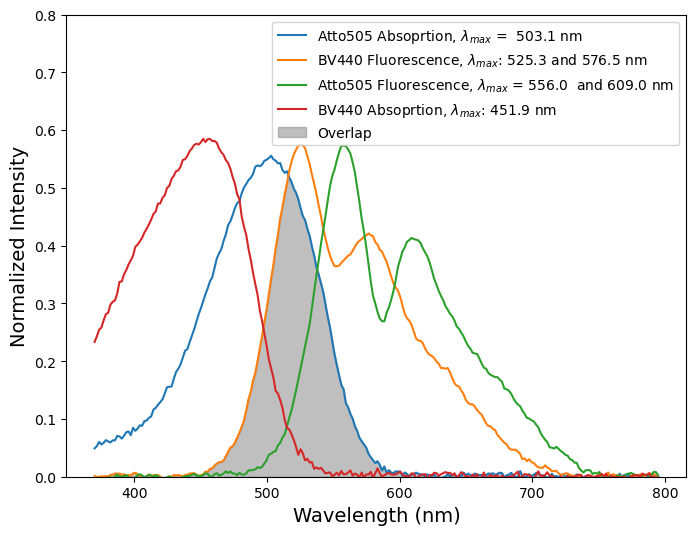

In [92]:
plt.plot(Atto505_abs_wavelength, Atto505_abs_OD, label=f'Atto505 Absoprtion, $\lambda_{{max}}$ =  {Atto505_abs_maxwavelength:.1f} nm')
plt.plot(BV440_flu_wavelength, BV440_flu_PC, label=f'BV440 Fluorescence, $\lambda_{{max}}$: {BV400_flu_maxwavelength:.1f} and {BV400_flu_maxwavelength2:.1f} nm')
plt.plot(Atto505_flu_wavelength, Atto505_flu_PC, label=f'Atto505 Fluorescence, $\lambda_{{max}}$ = {Atto505_flu_maxwavelength:.1f}  and {Atto505_flu_maxwavelength2:.1f} nm')
plt.plot(BV440_abs_wavelength, BV440_abs_OD, label=f'BV440 Absoprtion, $\lambda_{{max}}$: {BV400_abs_maxwavelength:.1f} nm')
# Calculate and plot the overlap
overlap = np.minimum(Atto505_abs_OD, BV440_flu_PC)
plt.fill_between(BV440_flu_wavelength, 0, overlap, color='gray', alpha=0.5, label='Overlap')

# Add labels and legend
plt.ylim(0,0.8)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Normalized Intensity', fontsize=14)
plt.legend()
plt.show()


- FRET
- large spectral overlap of donor emission with acceptor absorption
- limited to singlet-singlet transfer
- rate proportional to 1/r^6

In [93]:
6.626*10e-34 * 3*10e8 / (451.9*10e-9*1.602e-19)

27.457932508020654

---
## Q2
Discuss and interpret cross-sections through transient absorption spectrum at (at least) two representative times and two representative wavelengths

- compare with absorption and fluorescence
- GSB, SE and PIA regions

### TA
Each element shows the change in transmission dT/T at the corresponding time and wavelength  
$$ \Delta T  =T_{Pump\ on} - T_{Pump\ off}$$  
Pump pulse is intense and excites molecules  
3 main contributions to TA spectroscopy: GSB, SE and PIA

In [94]:
TA_data = np.loadtxt("TA_2D-DATA.mx3") # probe wavelngths along first row, pumo-probe delay down first column
probe_wavelengths = TA_data[0][1:] # first element is 0, so delete it
# each row is a different pump-probe delay
pump_probe_delays = TA_data[1:,0]
absorption_values = TA_data[1:,1:]


Time crossections

In [98]:
TA_data[1:,1:][0] # single row = single pump-probe delay
TA_data[1:,1:][:,0] # single column = single probe wavelength

array([-1.11312262e-06, -1.52451999e-04, -5.93155723e-05, ...,
        7.47475089e-05, -1.23075754e-05, -5.38486918e-05])

In [99]:
time_array = np.array([-2.5, 0, 0.1, 2.5, 5, 10, 20])
t_index_array = np.zeros(len(time_array))
for i in time_array:
    closest_index = np.abs(pump_probe_delays - i).argmin() # closest index to i ps delay
    t_index_array[time_array == i] = closest_index

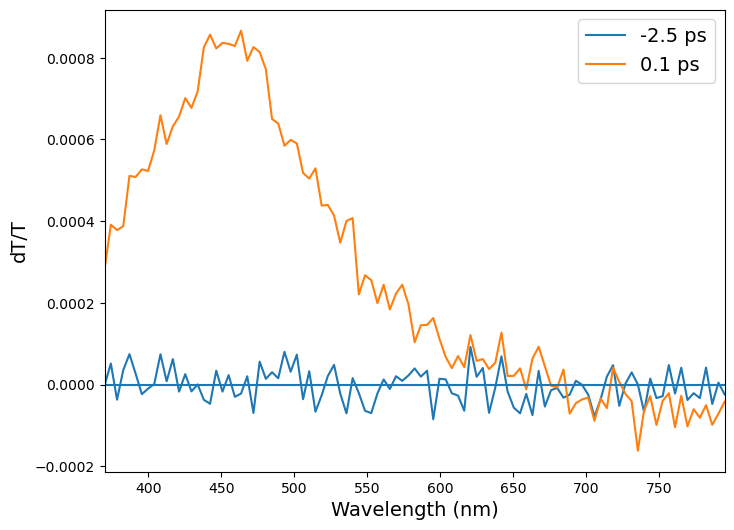

In [100]:
plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[0])], label=f"{time_array[0]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[1])], label=f"{time_array[1]} ps")
plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[2])], label=f"{time_array[2]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[3])], label=f"{time_array[3]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[4])], label=f"{time_array[4]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[5])], label=f"{time_array[5]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[6])], label=f"{time_array[6]} ps")

plt.hlines(0, 300, 800)

plt.xlim(min(probe_wavelengths), max(probe_wavelengths))
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('dT/T', fontsize=14)
plt.legend(fontsize=14)

BV440 initially excited

<font color='red'> scale to compare with absorption and emission spectra</font> 

<div>
<img src="TSQMS%20part%202%20images/2_TA_timecrossections.png" width="500"/>
</div>

No excitation seen at t = -2.5 ps meaning the probe pulse energy is too low for any excitation

PIA seen at higher wavelengths (-ve $dT/T$)  
- pump pulse pre-excites from GS to first excited state
- Probe pulse able to excite from 1st to 2nd excited state (lower energy gap)
- therefore usually red shifted from SE (lower E gap)
- At t = -2.5 ps, the probe pulse comes before the pump pulse therefore not PIA seen as pump pulse cant preexite as it comes later on.

overlaying abs spectra

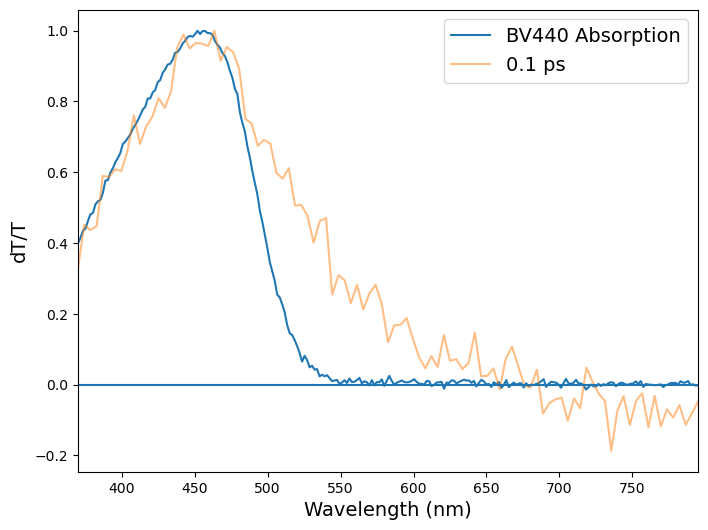

In [101]:
#plt.plot(Atto505_abs_wavelength, Atto505_abs_OD/max(Atto505_abs_OD), label=f'Atto505 Abs')
plt.plot(BV440_abs_wavelength, BV440_abs_OD/max(BV440_abs_OD), label=f'BV440 Absorption')
#plt.plot(BV440_flu_wavelength, BV440_flu_PC/max(BV440_flu_PC), label=f'BV440 Fluorescence')
#plt.plot(Atto505_abs_wavelength, Atto505_abs_OD/max(Atto505_abs_OD), label=f'Atto505 Abs')
#plt.plot(Atto505_flu_wavelength, Atto505_flu_PC/max(Atto505_flu_PC), label=f'Atto505 Flu')
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[0])], label=f"{time_array[0]} ps")
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[1])] / max(TA_data[1:,1:][int(t_index_array[1])]), label=f"{time_array[1]} ps", alpha = 1)
plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[2])] / max(TA_data[1:,1:][int(t_index_array[2])]), label=f"{time_array[2]} ps", alpha = 0.5)
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[3])] / max(TA_data[1:,1:][int(t_index_array[3])]), label=f"{time_array[3]} ps", alpha = 0.5)
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[4])] / max(TA_data[1:,1:][int(t_index_array[4])]), label=f"{time_array[4]} ps", alpha = 0.5)
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[5])] / max(TA_data[1:,1:][int(t_index_array[5])]), label=f"{time_array[5]} ps", alpha = 0.5)
#plt.plot(probe_wavelengths, TA_data[1:,1:][int(t_index_array[6])] / max(TA_data[1:,1:][int(t_index_array[6])]), label=f"{time_array[6]} ps", alpha = 0.5)

plt.hlines(0, 300, 800)

plt.xlim(min(probe_wavelengths), max(probe_wavelengths))
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('dT/T', fontsize=14)
plt.legend(fontsize=14)

0.1 ps:
- At very short times (0.1 ps), the GSB can be attributed to the BV400 absorption
- The SE part is likely due to fluoresnce from BV440 (how is FRET seen?)
- At higher wavelengths a small amount of PIA is seen

2.5 ps:
- GSB has contributions from BV440 and Atto505 absorption 
- increasing contribution from atto but decreasing from BV440 from comparison with earlier and later time slices

5 ps:
- GSB is at higher wavelengths, likely Atto505 absorption
- population of BV440 excited state (S1) decreasing
- slightly more PIA seen at longer times but not significantly more

20 ps:
- from 5 to 20 ps the spectrum is very similar
- possibly: lifetime for fluoresence long therefore slow decay and 

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joehart/opt/anacon

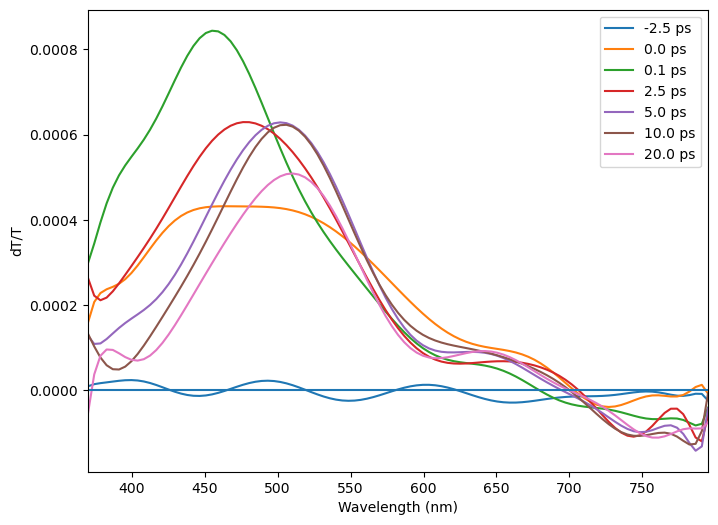

In [102]:
# isobestic?
for i in range(len(time_array)):
    fit = np.polyfit(probe_wavelengths, TA_data[1:,1:][int(t_index_array[i])], 20)
    fitted_C_values = np.polyval(fit, probe_wavelengths)
    plt.plot(probe_wavelengths, fitted_C_values, label=f'{time_array[i]} ps')

plt.hlines(0, 300, 800)
plt.xlim(min(probe_wavelengths), max(probe_wavelengths))
plt.xlabel('Wavelength (nm)')
plt.ylabel('dT/T')
plt.legend()


Wavelength crossections

In [103]:
wavelength_array = np.array([370, 500, 600, 750])
w_index_array = np.zeros(len(wavelength_array))
for i in wavelength_array:
    closest_index = np.abs(probe_wavelengths - i).argmin() # closest index to i ps delay
    w_index_array[wavelength_array == i] = closest_index

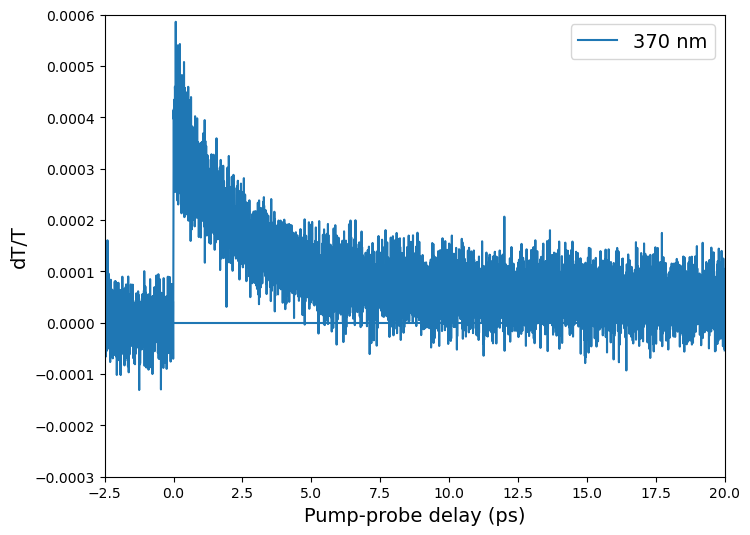

In [104]:
plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[0])], label=f"{wavelength_array[0]} nm")
#plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[1])], label=f"{wavelength_array[1]} nm")
#plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[2])], label=f"{wavelength_array[2]} nm")
#plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[3])], label=f"{wavelength_array[3]} nm")
plt.hlines(0, -2.5, 20)
plt.ylim(-0.0003,0.0006)

plt.xlim(min(pump_probe_delays), max(pump_probe_delays))
plt.xlabel('Pump-probe delay (ps)', fontsize=14)
plt.ylabel('dT/T', fontsize=14)
plt.legend(fontsize=14)

- find wavelength of peaks of GSB SE PIA 
- You can consider which molecule is excited more efficiently by the pump pulse by analysing the absorption spectra of the molecules at the pump wavelenght.

---
## Q3
Analyse the dynamics of the excited states and extract the timescale(s) of the dynamics using additional information provided by SVD or global fitting. Relate the identified timescales to the relevant dynamical processes on the Jablonski diagram proposed above.

- exponential fitting of kinetics + extract time constants
- short and long timescales
- critical discussion of SVD outcome
- analysis of SVD to identify timescales
- linear combinations
- Global analysis to confirm SVD conclusions

$$ \Delta T(t,\lambda) = \sum_{l=1}^N \varepsilon^l(\lambda)c^l(t) $$  
where $\varepsilon^l(\lambda)$ is the spectrum of excited state l, $c^l(t)$ is the number of excited states l at time t.

But in experiment we use discreet $t_i$ and $\lambda_i$: $$ \Delta T_{ij} = \sum_{l=1}^N c_i^l\varepsilon_j^l $$  
$c_i^l$ - number of the excited state i existing at the delay time t  
$\varepsilon_j^l$ - change in transmission at the wavelengh λ upon the formation of a single excited state i. If transmission increases- ε is positve, and if transmission decreeses - ε is negative. (TA spectrum of state)

Assumptions:  
- N types of excited states contributing (not $\infty$)
  - e.g. charge transfer and exciton state
  - evaluate data as superposition of states
- spectral responses are time-independent (crude approx.)
  - e.g. exciton will give the same TA response at any moment in time

Artem:
- you have already discussed that populations of states should not be negative

- you can assume that at the early times after excitation only one excited state is initially populated and population of another state is zero

- you can assume certain processes have 0% or 100% efficiencly. 


These assumption(s), if formulated and used correctly, will lead to a unique linear combination reflecting the evolution of the population of a specific excited state.


Concerning N - all linear combination use the same number of components, therefore, N provided by SVD analysis is relevant.

### SVD

Contour plot of TA spectrum

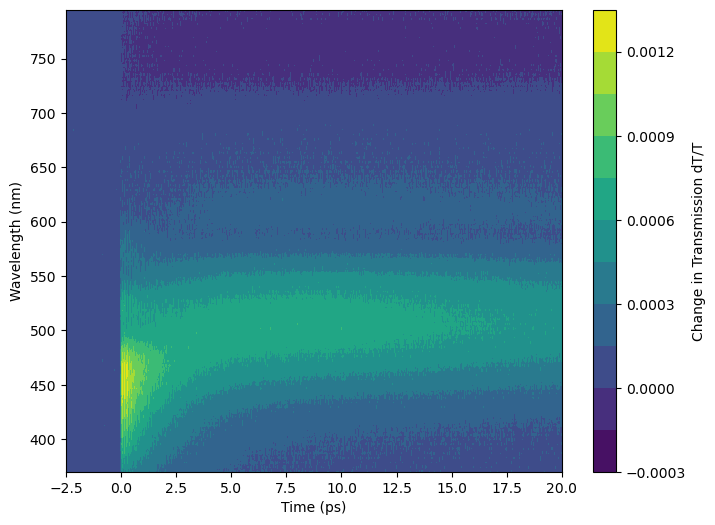

In [105]:
contour = plt.contourf(time_grid, wavelength_grid, absorption_values, cmap='viridis', levels = 10)
plt.xlabel('Time (ps)')
plt.ylabel('Wavelength (nm)')
plt.colorbar(contour, label='Change in Transmission dT/T')

plt.show()

<div>
<img src="TSQMS%20part%202%20images/4_TA_contour.png" width="400"/>
</div>

In [106]:
U, singular_values, V = np.linalg.svd(absorption_values)
S = np.diag(singular_values) # create diagonal matrix from singular values
# TA data = m x n (7501 x 101)
# 3 matrices: U (m x m), S (m x n), V (n x n)
# V is alredy transposed
# contribution of first (l=1) excited state, 2nd excited state, other excited states and noise
# each 

<font color='red'>Only consider components that are greater than 5-10% of the value of</font> $\sigma^1$

Text(0, 0.5, 'Singular value')

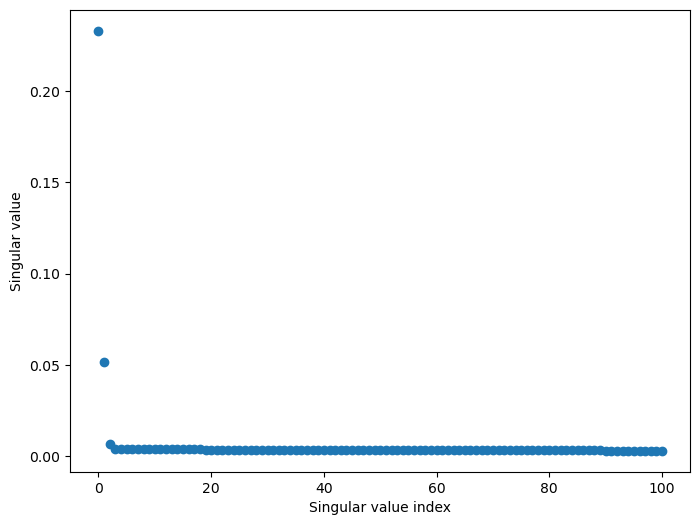

In [107]:
# S is m x n diagonal matrix: extracts the n diagonal values for you
# only first 2 excited states have sigma values > 0.05
plt.plot(singular_values, 'o')
plt.xlabel("Singular value index")
plt.ylabel("Singular value")

<div>
<img src="TSQMS%20part%202%20images/7_singlarvalueplot.png" width="300"/>
</div>

In [108]:
singular_values[singular_values > 0.05*singular_values[0]]

array([0.233214 , 0.0516782])

In [109]:
# Choose only the first 2 singular values as theyre the only ones > 5% sigma^1
U_2 = U[:, :2]
S_2 = np.diag(singular_values[:2])
V_2 = V[:2, :]

U_2_normalised = np.dot(U_2, S_2) # neccesarry?

New TA using absorption values only from significant states, reducing noise significantly.

In [110]:
S_2

array([[0.233214 , 0.       ],
       [0.       , 0.0516782]])

In [111]:
# reconstruct the TA data with only the first 2 excited states
absorption_values_approx = np.dot(np.dot(U_2, S_2), V_2)

In [116]:
%matplotlib inline

In [117]:
S_comb = np.diag(np.array([3.6, 1]))
S_comb2 = np.diag(np.array([0.5, -1]))

In [118]:
absorption_values_approx2 = np.dot(np.dot(U_2, S_comb), V_2)
absorption_values_approx3 = np.dot(np.dot(U_2, S_comb2), V_2)


### Kinetics

- Populations of excited states (c) cant be negative  
- Can assume at the early times, only one excited state is initially populated and the population of the other state is zero
- assume processes have either 0% or 100% efficiency
- aim is a unique linear combination  reflecting the evolution of the population of a specific excited state. 

In [121]:
%matplotlib inline

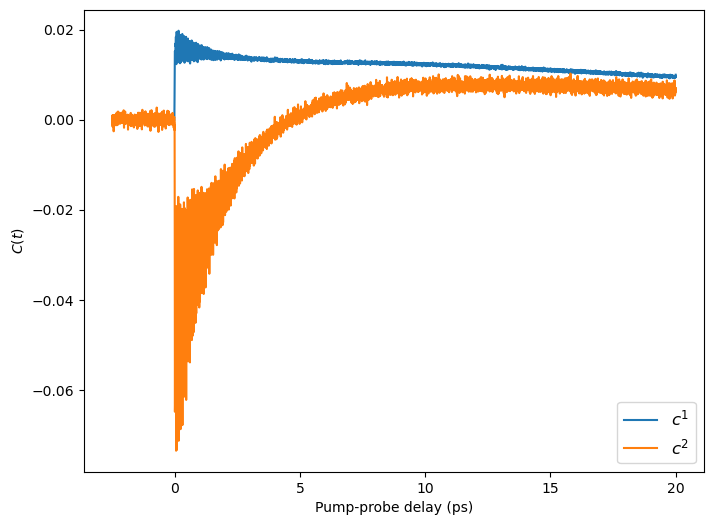

In [122]:
plt.plot(pump_probe_delays, U_2[:, 0], label='$c^1$')
plt.plot(pump_probe_delays, U_2[:, 1], label='$c^2$')

plt.xlabel('Pump-probe delay (ps)')
plt.ylabel('$C(t)$')
plt.legend(loc = 'lower right', fontsize = 12)
plt.show()

<div>
<img src="TSQMS%20part%202%20images/5_svd_kinetics.png" width="400"/>
</div>

In [123]:
pump_probe_delays[pump_probe_delays>0]

array([2.0000e-03, 5.0000e-03, 8.0000e-03, ..., 1.9994e+01, 1.9997e+01,
       2.0000e+01])

$c^1 + c^2$ : Initial excitation gives negative population therefore unphysical

In [124]:
%matplotlib inline

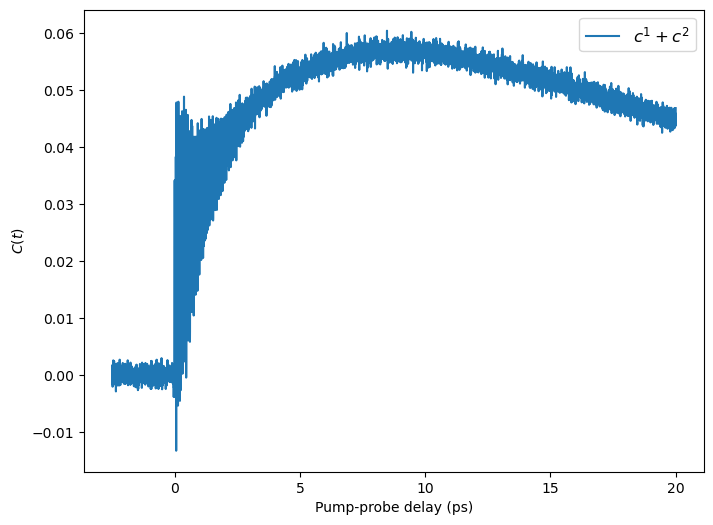

In [125]:
comb_add_kin = singular_values[0]*U_2[:, 0] + singular_values[1]*U_2[:, 1]
comb_add_kin2 = 4*U_2[:, 0] + U_2[:, 1]

plt.plot(pump_probe_delays, comb_add_kin2, label='$c^1 + c^2$')

plt.xlabel('Pump-probe delay (ps)')
plt.ylabel('$C(t)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

- Population of SN via PIA

<div>
<img src="TSQMS%20part%202%20images/10_c1+c2.png" width="400"/>
</div>

$c^1 - c^2$

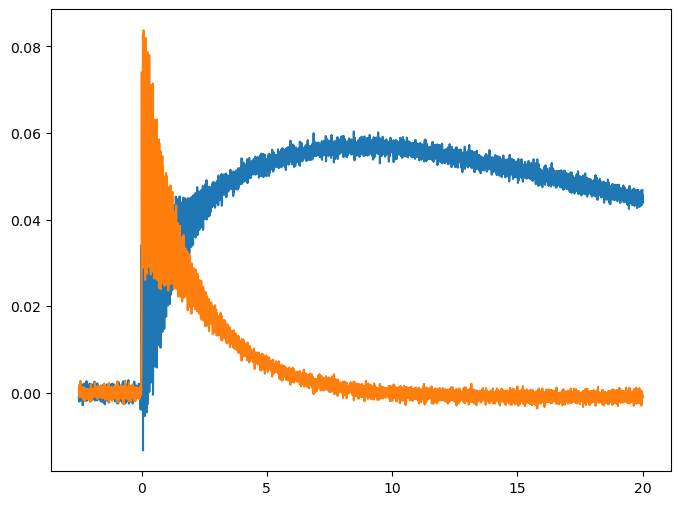

In [128]:
comb_add2 = 0.6*U_2[:, 0] - U_2[:, 1]
comb_add_kin2 = 4*U_2[:, 0] + U_2[:, 1]

plt.plot(pump_probe_delays, comb_add_kin2, label='$c^1 + c^2$')

plt.plot(pump_probe_delays, comb_add2, label='$c^1 - c^2$')


<div>
<img src="TSQMS%20part%202%20images/8_c(t)_c1-c2.png" width="300"/>
<img src="TSQMS%20part%202%20images/2_c(t)_c1-c2_singular.png" width="300"/>
</div>

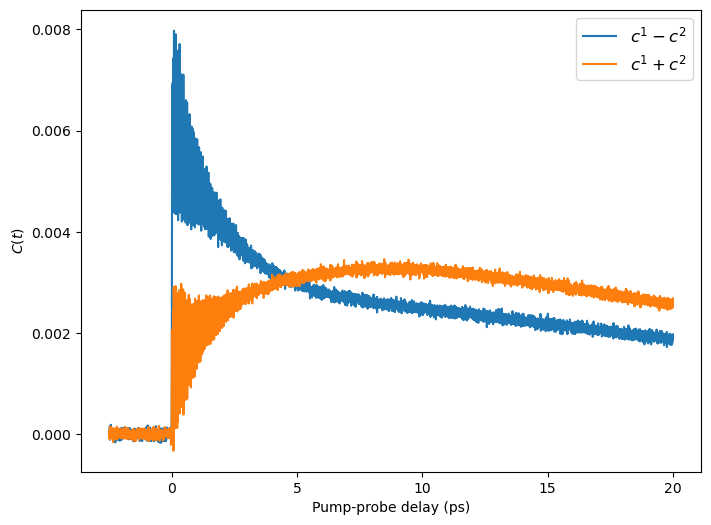

In [129]:
comb_minus_kin = singular_values[0]*U_2[:, 0] - singular_values[1]*U_2[:, 1]

plt.plot(pump_probe_delays, comb_minus_kin, label='$c^1 - c^2$')

comb_add_kin = singular_values[0]*U_2[:, 0] + singular_values[1]*U_2[:, 1]

plt.plot(pump_probe_delays, comb_add_kin, label='$c^1 + c^2$')


plt.xlabel('Pump-probe delay (ps)')
plt.ylabel('$C(t)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

Thoughts: Determine expected lifetime for this and then try to make a linear combinatioon which has this lifetime (time to drop to 1/e)

lifetime fluorescence: 1/rate, rate = 10^6 - 10^9 s^-1 (photochemistry lectures)
life time = 10^-6 - 10^-9

Lifetime of fluoresnce dyes in the visible range is on the scale of nano seconds (not sure but have a reference): https://pubs.acs.org/doi/10.1021/jacs.2c05826

In [132]:
%matplotlib inline

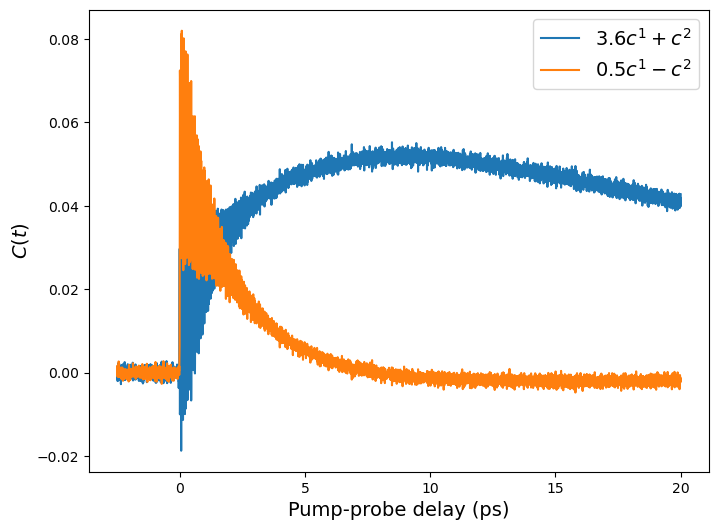

In [133]:
comb_kin1 = 3.6*U_2[:, 0] + U_2[:, 1]
comb_spec1 = 3.6*V_2[0] + V_2[1]


comb_kin2 = 0.5*U_2[:, 0] - U_2[:, 1]
comb_spec2 = 0.5*V_2[0] - V_2[1]

# plt.plot(probe_wavelengths, comb_spec1/trapz(comb_spec1), label='$3.6 \epsilon^1 + \epsilon^2$')
# plt.plot(probe_wavelengths, comb_spec2/trapz(comb_spec2), label='$0.5 \epsilon^1 - \epsilon^2$')
# plt.xlabel('Wavelegnth (nm)', fontsize = 14)
# plt.ylabel('$\epsilon(\lambda)$', fontsize = 14)
# plt.legend(loc = 'upper right', fontsize = 14)
# plt.show()

plt.plot(pump_probe_delays, comb_kin1, label='$3.6 c^1 + c^2$')
plt.plot(pump_probe_delays, comb_kin2, label='$0.5 c^1 - c^2$')
plt.xlabel('Pump-probe delay (ps)', fontsize = 14)
plt.ylabel('$C(t)$', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 14)
plt.show()


### Spectra

- Only one state populated at early times, thererfore only GSB at early times
- GSB small times scale


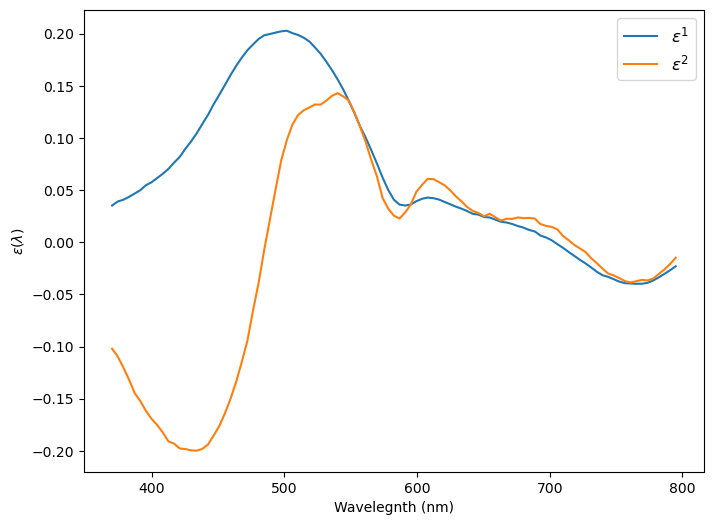

In [134]:
plt.plot(probe_wavelengths, V_2[0], label='$\epsilon^1$')
plt.plot(probe_wavelengths, V_2[1], label='$\epsilon^2$')

plt.xlabel('Wavelegnth (nm)')
plt.ylabel('$\epsilon(\lambda)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

<div>
<img src="TSQMS%20part%202%20images/6_svd_spectra.png" width="400"/>
</div>

$\varepsilon^1 + \varepsilon^2$

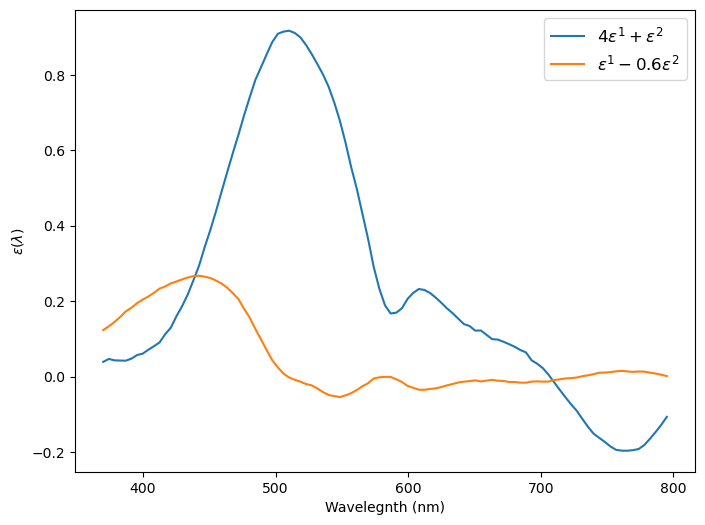

In [135]:
#plt.plot(probe_wavelengths, singular_values[0]*V_2[0] + singular_values[1]*V_2[1], label='$\epsilon^1 + \epsilon^2$')
plt.plot(probe_wavelengths, 4*V_2[0] + V_2[1], label='$4 \epsilon^1 + \epsilon^2$')
plt.plot(probe_wavelengths, 0.6*V_2[0] - V_2[1], label='$\epsilon^1 - 0.6 \epsilon^2$')


plt.xlabel('Wavelegnth (nm)')
plt.ylabel('$\epsilon(\lambda)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

<div>
<img src="TSQMS%20part%202%20images/11_e1+e2.png" width="400"/>
</div>

In [136]:
probe_wavelengths[argmax(singular_values[0]*V_2[0] + singular_values[1]*V_2[1])]

510.25

$\varepsilon^1 - \varepsilon^2$

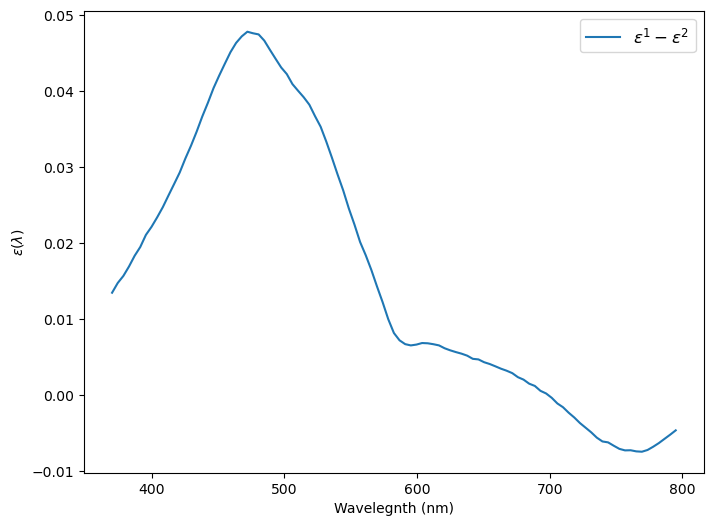

In [137]:
plt.plot(probe_wavelengths, singular_values[0]*V_2[0] - singular_values[1]*V_2[1], label='$\epsilon^1 - \epsilon^2$')

plt.xlabel('Wavelegnth (nm)')
plt.ylabel('$\epsilon(\lambda)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()

In [138]:
probe_wavelengths[argmax(singular_values[0]*V_2[0] - singular_values[1]*V_2[1])]

472.0

<div>
<img src="TSQMS%20part%202%20images/12_e1-e2_scaled.png" width="400"/>
</div>

Concerning finding A1, A2, B1, B2: If you assume that only one excited state is created at early time e.g. 100fs, then c2*(t=100fs) =0 and your TA spectrum at (t=100fs) can be presented as: dT(100fs, λ)=ε1*(λ)*c1*(100fs)=const*(A1 ε1(λ) + B1 ε2(λ)). Playing with relative weights of ε1 and ε2 to reproduce the sape of TA spectrum should allow you to get estimates for A1 and B1. It should be then pretty straightforward to get A2 B2.

If you assume the early time is 100fs for example, you can write the above:

dT (λ) $\approx$ to ε1*(λ) c1*(100fs)   (not presisely as we ignore all the components except the first N (2) of them)

ε1*(λ) = A1 ε1(λ) + B1 ε2(λ) 

ε1*(λ) c1*(t) = A1 c1(t) ε1(λ) + B1 c2(t) ε2(λ) 

ε2*(λ) c2*(t) = A2 c1(t) ε1(λ) + B2 c2(t) ε2(λ) 

From these equations it is possible to determine to suggest A1 and B1. there is no single solution as we are describing full dataset by just two components out of many but it should be possible to suggest a combination.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


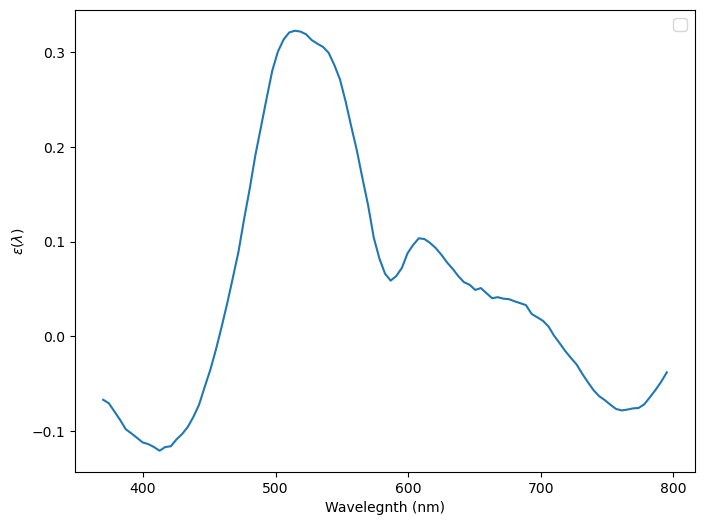

In [139]:
A1 = 1
B1 = 1
const = 1
linear_comb = const * (A1 * V_2[0] + B1 * V_2[1])


plt.plot(probe_wavelengths, linear_comb)# , label='$\epsilon^1 - \epsilon^2$')

plt.xlabel('Wavelegnth (nm)')
plt.ylabel('$\epsilon(\lambda)$')
plt.legend(loc = 'upper right', fontsize = 12)
plt.show()


### Timescales

Consider the relative timescales of different processes (e.g., radiative decay, non-radiative decay, intersystem crossing) and identify which processes in the Jablonski diagram correspond to the timescales extracted from the SVD analysis.

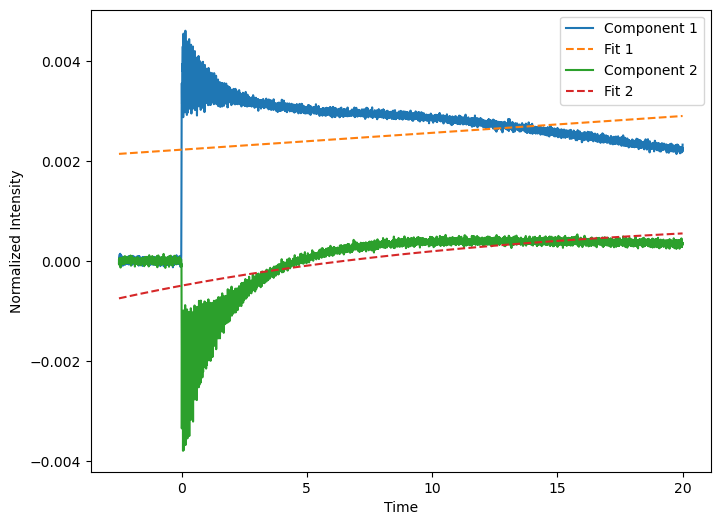

In [140]:
# chat
def exponential_decay(t, amplitude, time_constant, offset):
    return amplitude * np.exp(-t / time_constant) + offset

time_constants = []

for i in range(2):
    time_trace = U_2_normalised[:, i]
    popt_exp, _ = curve_fit(exponential_decay, pump_probe_delays, time_trace, p0=(time_trace[0], 1, 0))
    amplitude, time_constant, offset = popt
    time_constants.append(time_constant)
    plt.plot(pump_probe_delays, time_trace, label=f"Component {i + 1}")
    plt.plot(pump_probe_delays, exponential_decay(pump_probe_delays, *popt_exp), linestyle="--", label=f"Fit {i + 1}")

plt.xlabel("Time")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()

In [141]:
def exp_dec(x, a, b, c):
    return a*np.exp(-b*x) + c

delays = pump_probe_delays[pump_probe_delays>0]
delays2 = pump_probe_delays[pump_probe_delays>10]
no_delays = len(pump_probe_delays[pump_probe_delays<0])  
no_delays2 = len(pump_probe_delays[pump_probe_delays<10])  


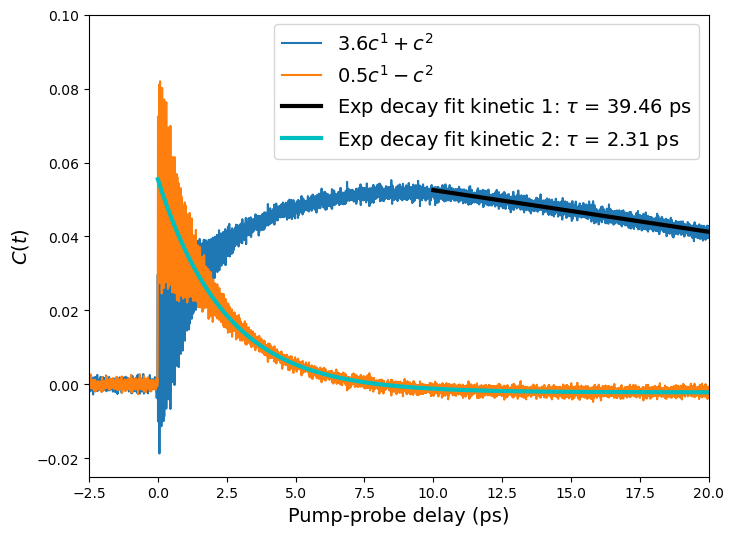

In [142]:
popt_dec1, pcov_dec1 = curve_fit(exp_dec, delays2, comb_kin1[no_delays2:], p0=[0.1, 0.1, 0.1], maxfev = 5000)
popt_dec2, pcov_dec2 = curve_fit(exp_dec, delays, comb_kin2[no_delays:], p0=[0.1, 0.1, 0.1], maxfev = 5000)

plt.plot(pump_probe_delays, comb_kin1, label='$3.6 c^1 + c^2$')
plt.plot(pump_probe_delays, comb_kin2, label='$0.5 c^1 - c^2$')

delays3 = np.linspace(10,100,1000)

y_exp = exp_dec(delays3, *popt_dec1)
tau_c = y_exp[0]/np.e
tau = delays3[np.abs(y_exp - tau_c).argmin()]

plt.plot(delays3, y_exp, label = r'Exp decay fit kinetic 1: $\tau$ = ' + str(round(tau,2)) + ' ps', c='k', linewidth=3)


y_exp2 = exp_dec(delays, *popt_dec2)
tau_c2 = y_exp2[0]/np.e
tau2 = delays[np.abs(y_exp2 - tau_c2).argmin()]


plt.plot(delays, y_exp2, label = r'Exp decay fit kinetic 2: $\tau$ = ' + str(round(tau2,2)) + ' ps', linewidth=3, c='c')
plt.ylim(-0.025,0.1)

plt.xlim(-2.5, 20)
plt.xlabel('Pump-probe delay (ps)', fontsize = 14)
plt.ylabel('$C(t)$', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 14)
plt.show()

In [143]:
tau

39.45945945945946

A = 0.02488983635125343 tau = -0.8799337752545991 beta = 9.839429989040573


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_69738/2950349780.py:6: RuntimeWarning: overflow encountered in exp
  exponential_decay = np.exp(-lambd * (x - mu))
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_69738/2950349780.py:7: RuntimeWarning: invalid value encountered in multiply
  return gaussian * exponential_decay


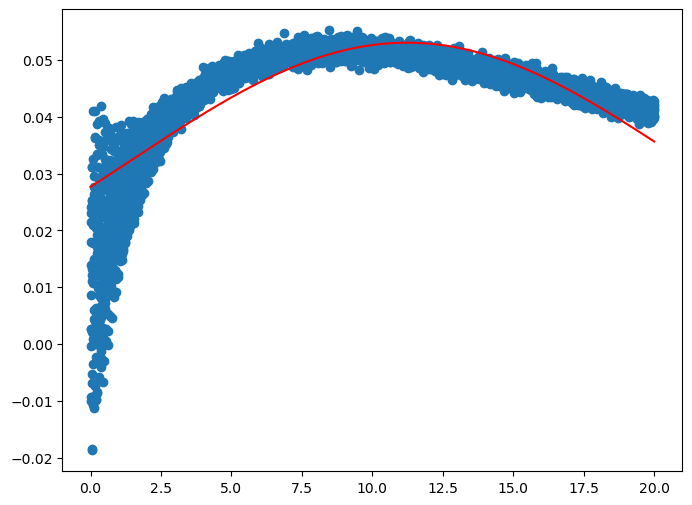

In [144]:
def stretched_exponential(t, A, tau, beta):
    return A * np.exp(-(t/tau)**beta)

def combined_function(x, A, mu, sigma, lambd):
    gaussian = A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    exponential_decay = np.exp(-lambd * (x - mu))
    return gaussian * exponential_decay

# Fit the stretched exponential function to the data
popt, pcov = curve_fit(combined_function, delays, comb_kin1[no_delays:], maxfev = 5000)

# Print the fitted parameters
print("A =", popt[0], "tau =", popt[1], "beta =", popt[2])


# Plot the data and the fitted curve
t = np.linspace(0, 20, 1000)
plt.plot(delays, comb_kin1[no_delays:], 'o', label='Auto-correlation')
plt.plot(t, combined_function(t, *popt), label="Fitted Function", color="red")
#plt.vlines(tau, -1, 1/e, linestyle='--', color='k', label=r'$\tau$ = 46.9 a.u.')

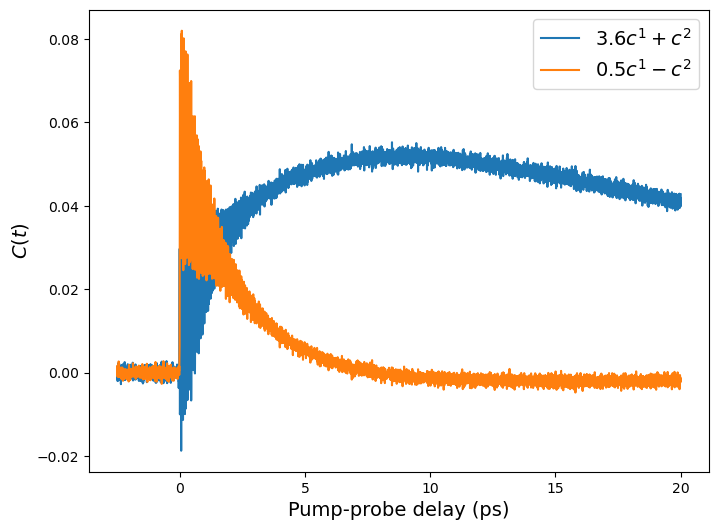

In [145]:
comb_kin1 = 3.6*U_2[:, 0] + U_2[:, 1]
comb_kin2 = 0.5*U_2[:, 0] - U_2[:, 1]





plt.plot(pump_probe_delays, comb_kin1, label='$3.6 c^1 + c^2$')
plt.plot(pump_probe_delays, comb_kin2, label='$0.5 c^1 - c^2$')
plt.xlabel('Pump-probe delay (ps)', fontsize = 14)
plt.ylabel('$C(t)$', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 14)
plt.show()

Checking if physical: The simplest check is that populations are not (too) negative.  
You can indeed push it further by also looking at ε*1 and ε*2 and identifying GSB, SE and PIA for individual states. (this goes a bit beyound what I normally expect, but some students do it).

---
## Q4
Where possible, identify the vibrational modes of BV440 and Atto505 (use multiple approaches if you can). Assign the observed vibrational coherences (if any) to the electronic states.

- isolate oscillatory component and do fourier transform
- interpret x-axis after FT and convert to cm-1
- often multiple vibrational modes hidden in the noisy data, need to identify
- common mistakes: 
    - not subtracting slow compoent correctly
    - doing analysis only on specific frequencies without averaging (leading to noisy data)
- assign vibrational coherence to state based on the time and spectral characteristics of oscillatory signals

- find residual:
    - crossections at different wavelength
    - exp fit kinetics
    - residual = data - fit
    - IFT of residual
    - can do multiple over a range of wavelengths and calc mean

In [146]:
%matplotlib inline

In [147]:
wavelength_array = np.array([370, 400, 500, 600, 700])
w_index_array = np.zeros(len(wavelength_array))
for i in wavelength_array:
    closest_index = np.abs(probe_wavelengths - i).argmin() # closest index to i ps delay
    w_index_array[wavelength_array == i] = closest_index

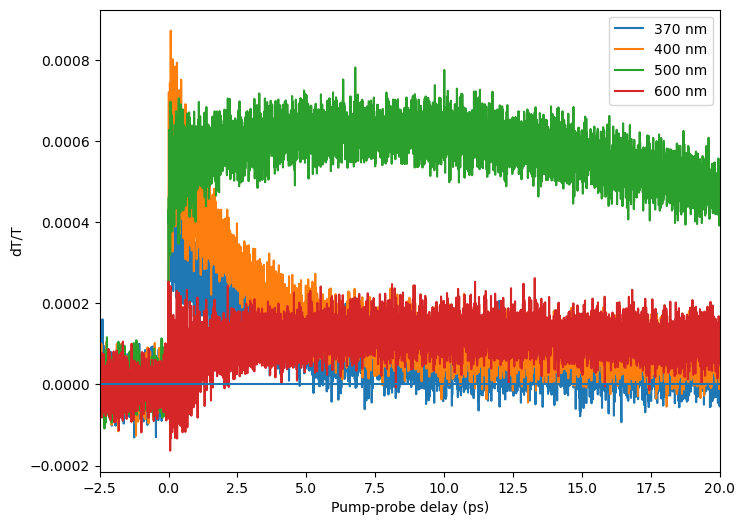

In [148]:
plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[0])], label=f"{wavelength_array[0]} nm")
plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[1])], label=f"{wavelength_array[1]} nm")
plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[2])], label=f"{wavelength_array[2]} nm")
plt.plot(pump_probe_delays, TA_data[1:,1:][:,int(w_index_array[3])], label=f"{wavelength_array[3]} nm")
plt.hlines(0, -2.5, 20)

plt.xlim(min(pump_probe_delays), max(pump_probe_delays))
plt.xlabel('Pump-probe delay (ps)')
plt.ylabel('dT/T')
plt.legend()

In [150]:
from numpy.fft import fft,ifft,fftshift,ifftshift,fftfreq

In [152]:
def res(n):
    TA_dat1 = TA_data[1:,1:][:,int(w_index_array[n])]

    popt_dec1, pcov_dec1 = curve_fit(exp_dec, delays, TA_dat1[no_delays:], p0=[0.1, 0.1, 0.1], maxfev = 5000)

    res1 = TA_dat1[no_delays:] - exp_dec(delays, *popt_dec1)

    #plt.plot(delays, TA_dat1[no_delays:], label=f"Raw {wavelength_array[n]} nm")
    #plt.plot(delays, res1, label=f"Residual {wavelength_array[n]} nm")
    #plt.plot(delays, exp_dec(delays, *popt_dec1), label=f"fit {wavelength_array[n]} nm", linewidth=3)
    plt.legend(loc="upper right", fontsize = 14)
    plt.show()
    
    #plt.figure()
    freq = 33.3*fftshift(fftfreq(len(delays),d=(delays[2]-delays[1]))) 

    power_370 = fftshift(fft(res1, norm='ortho'))

    pw_370 = abs(power_370)**2
    positive_freq = freq[freq>0]
    negative_freq = freq[freq<0]

    plt.plot(positive_freq, pw_370[len(negative_freq)+1:])
    plt.ylabel("Intensity (a.u.)", fontsize = 14)
    plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize = 14)
    plt.show()
    return positive_freq, pw_370[len(negative_freq)+1:]

In [154]:
res_370[1]

array([1.56774990e-08, 2.48829868e-09, 1.74732306e-10, ...,
       7.85743050e-10, 6.81979404e-10, 1.35055385e-09])

Text(0, 0.5, 'Intensity (a.u.)')

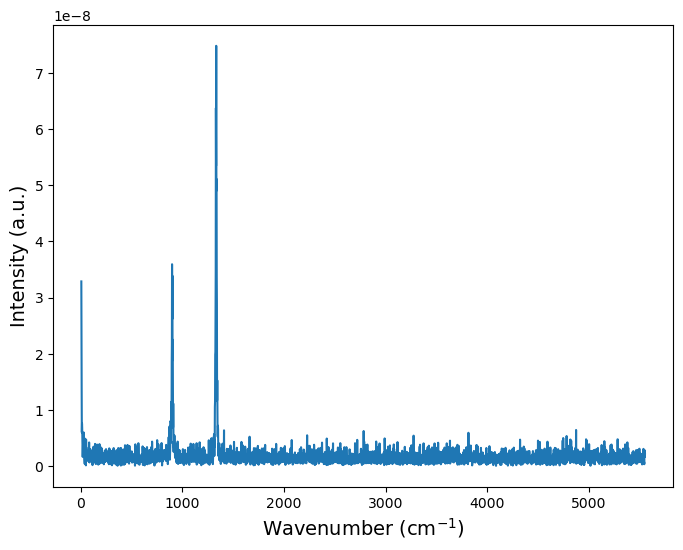

In [160]:
res_avg = (res_370[1] + res_400[1] + res_500[1])/3

plt.plot(res_370[0][2:], res_avg[2:], label="Average")
plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=14)
plt.ylabel("Intensity (a.u.)", fontsize=14)

## contour attempt

In [161]:
wavelength_array = np.linspace(370, 750, 100)
#wavelength_array = np.array([370, 500, 600, 750])
w_index_array = np.zeros(len(wavelength_array))
for i in wavelength_array:
    closest_index = np.abs(probe_wavelengths - i).argmin() # closest index to i ps delay
    w_index_array[wavelength_array == i] = closest_index

In [162]:

freq_2D = []
pw_2D = []

for i in range(len(wavelength_array)): 
    TA_dat1 = TA_data[1:,1:][:,int(w_index_array[i])]

    popt_dec1, pcov_dec1 = curve_fit(exp_dec, delays, TA_dat1[no_delays:], p0=[0.1, 0.1, 0.1], maxfev = 5000)

    res1 = TA_dat1[no_delays:] - exp_dec(delays, *popt_dec1)

    freq1 = 33.3 * fftshift(fftfreq(len(delays), d=(delays[2]-delays[1]))) 

    power_370 = fftshift(fft(res1, norm='ortho'))

    pw_370 = abs(power_370)**2
    positive_freq1 = freq1[freq1>0]
    negative_freq = freq1[freq1<0]
    
    freq_2D.append(positive_freq1.tolist())
    pw_2D.append(pw_370[len(negative_freq)+1:].tolist())


In [163]:
len(pw_2D)

100

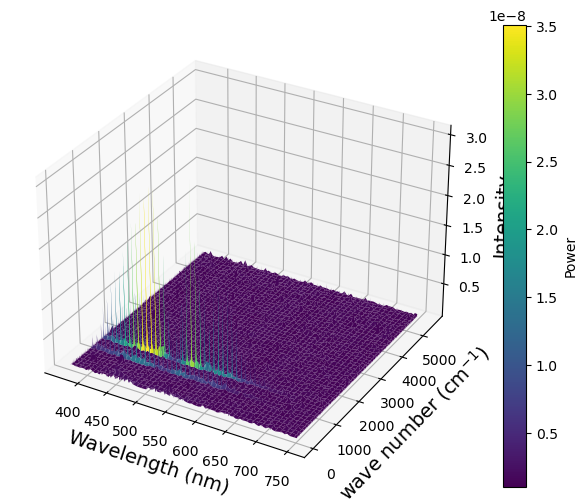

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert lists to NumPy arrays
freq_2D_array = np.array(freq_2D)[:,20:]
pw_2D_array = np.array(pw_2D)[:,20:]

# Create a meshgrid for the X, Y, and Z coordinates
wavelength_mesh, freq_mesh = np.meshgrid(wavelength_array, freq_2D_array[0], indexing='ij')

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(wavelength_mesh, freq_mesh, pw_2D_array, cmap='viridis', linewidth=10)

# Add colorbar
fig.colorbar(surface, ax=ax, label='Power')

# Set axis labels
ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('wave number (cm$^{-1}$)', fontsize=14)
ax.set_zlabel('Intensity', fontsize=14)

# Show the plot
plt.show()


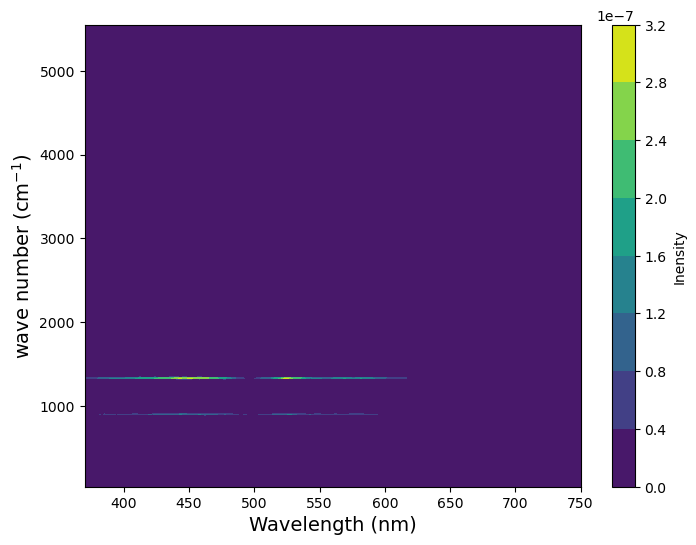

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to NumPy arrays
freq_2D_array = np.array(freq_2D)[:, 20:]
pw_2D_array = np.array(pw_2D)[:, 20:]

# Create a meshgrid for the X and Y coordinates
wavelength_mesh, freq_mesh = np.meshgrid(wavelength_array, freq_2D_array[0], indexing='ij')

# Create a 2D plot
fig, ax = plt.subplots()

# Plot the 2D contour heatmap
contour = ax.contourf(wavelength_mesh, freq_mesh, pw_2D_array, cmap='viridis')

# Add colorbar
fig.colorbar(contour, ax=ax, label='Inensity')

# Set axis labels
ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('wave number (cm$^{-1}$)', fontsize=14)

# Show the plot
plt.show()
